In [16]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Time series

A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. Examples of time series are heights of ocean tides, counts of sunspots, and the daily closing value of the Dow Jones Industrial Average.

Time series are very frequently plotted via line charts. Time series are used in statistics, signal processing, pattern recognition, econometrics, mathematical finance, weather forecasting, earthquake prediction, control engineering, astronomy, communications engineering, and largely in any domain of applied science and engineering which involves temporal measurements.

## Time Series Forecasting

Time series forecasting is the use of a model to predict future values based on previously observed values.



# Keras Example 

Lets use a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/). It contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, we will use only the data collected between 2009 and 2016.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As our time series resolution is every 10 minutes, thus we have 10 samples in an hour and a a day will contain 6 * 24 = 144 samples.

In time series forecasting we usually define how many samples we wish to predict for in the future, say we were interested in predicting the next 6 hours. In order to make such a prediction we could create a window containing the last 5 days of samples (a window containing 5 * 144 = 720 samples).

Given a specific time, let's say we want to predict the temperature 6 hours in the future. In order to make this prediction, we could choose to use 5 days of samples. Thus, we would create a window containing the last 720(5x144) samples to train the model. Many configurations are possible, and these would form the models hyper parameters.

Lets create a function that returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

Lets use the first 2,100 days of samples for training which is approximately the frist 300,000 rows of the dataset.


In [4]:
TRAIN_SPLIT = 300000

## Forecasting a univariate time series
First lets train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [29]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this temperature data looks across time.

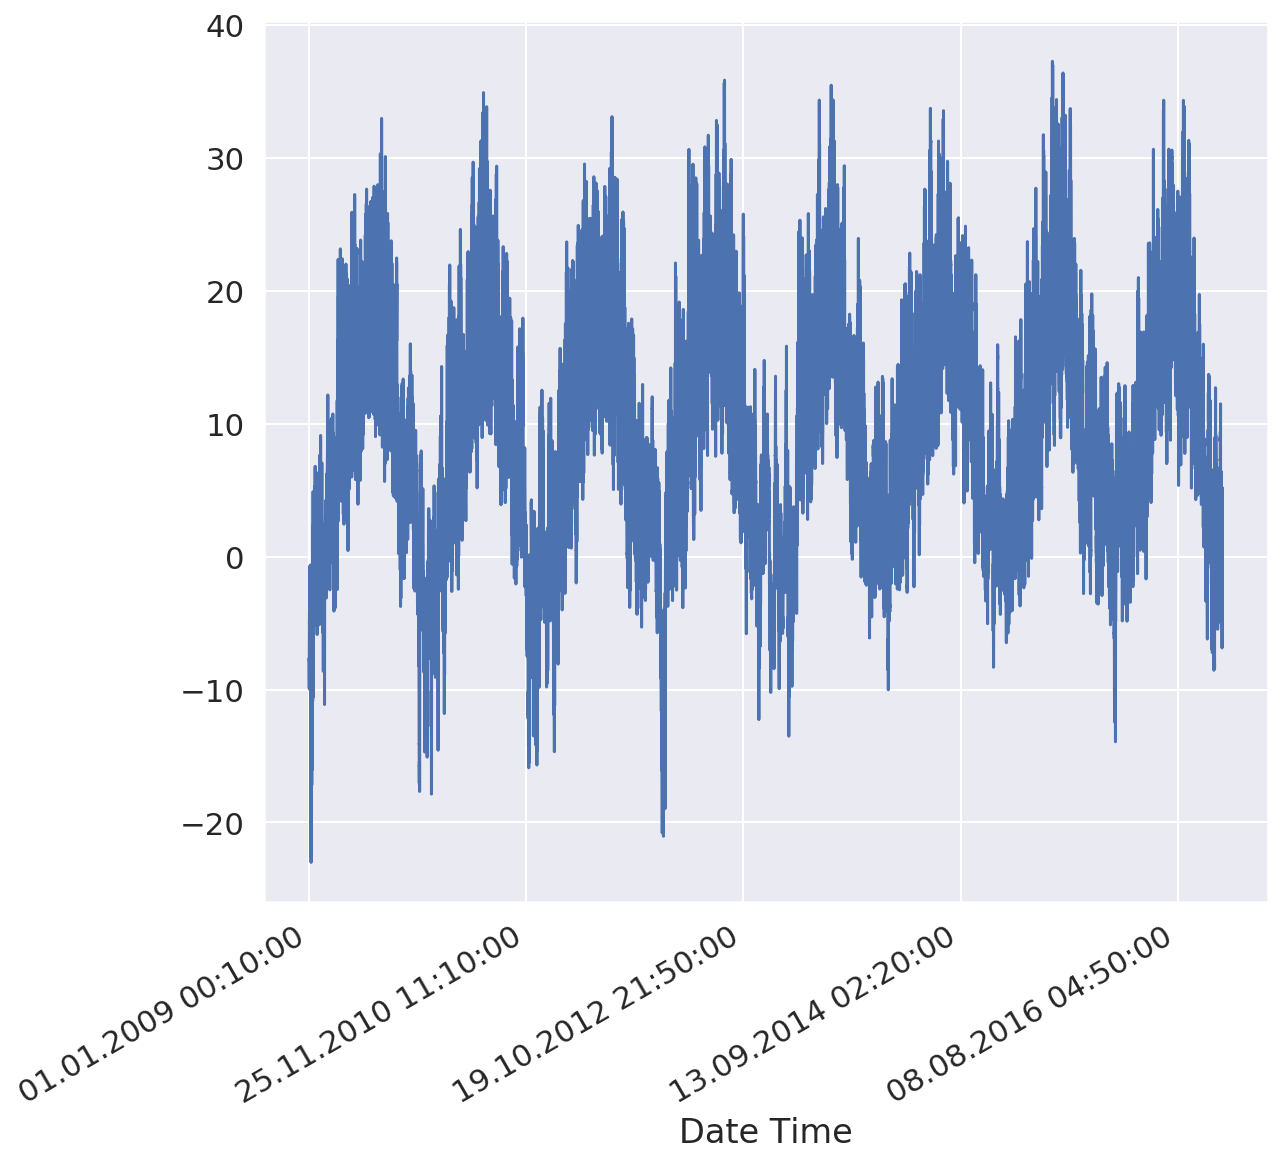

In [30]:
uni_data.plot(subplots=True)
plt.show()

In [31]:
# Extract numpy array of samples out
uni_data = uni_data.values.reshape(-1, 1)

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature, to make the input data take that of a gaussian with zero mean and unit standard deviation. We could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1]. Here lets use Sklearn pre-processing pipeline.

Here the mean and standard deviation should only be computed using the training data. And then transformed on the entire dataset.

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(uni_data[:TRAIN_SPLIT])
uni_data_scaled = scaler.transform(uni_data)

Let's now create the data for the univariate model. Lets give the model the last 20 recorded temperature samples, and it will be trained to predict the next temperature sample at the next timestep. 

In [36]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_scaled, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [37]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
[-2.10418486]


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

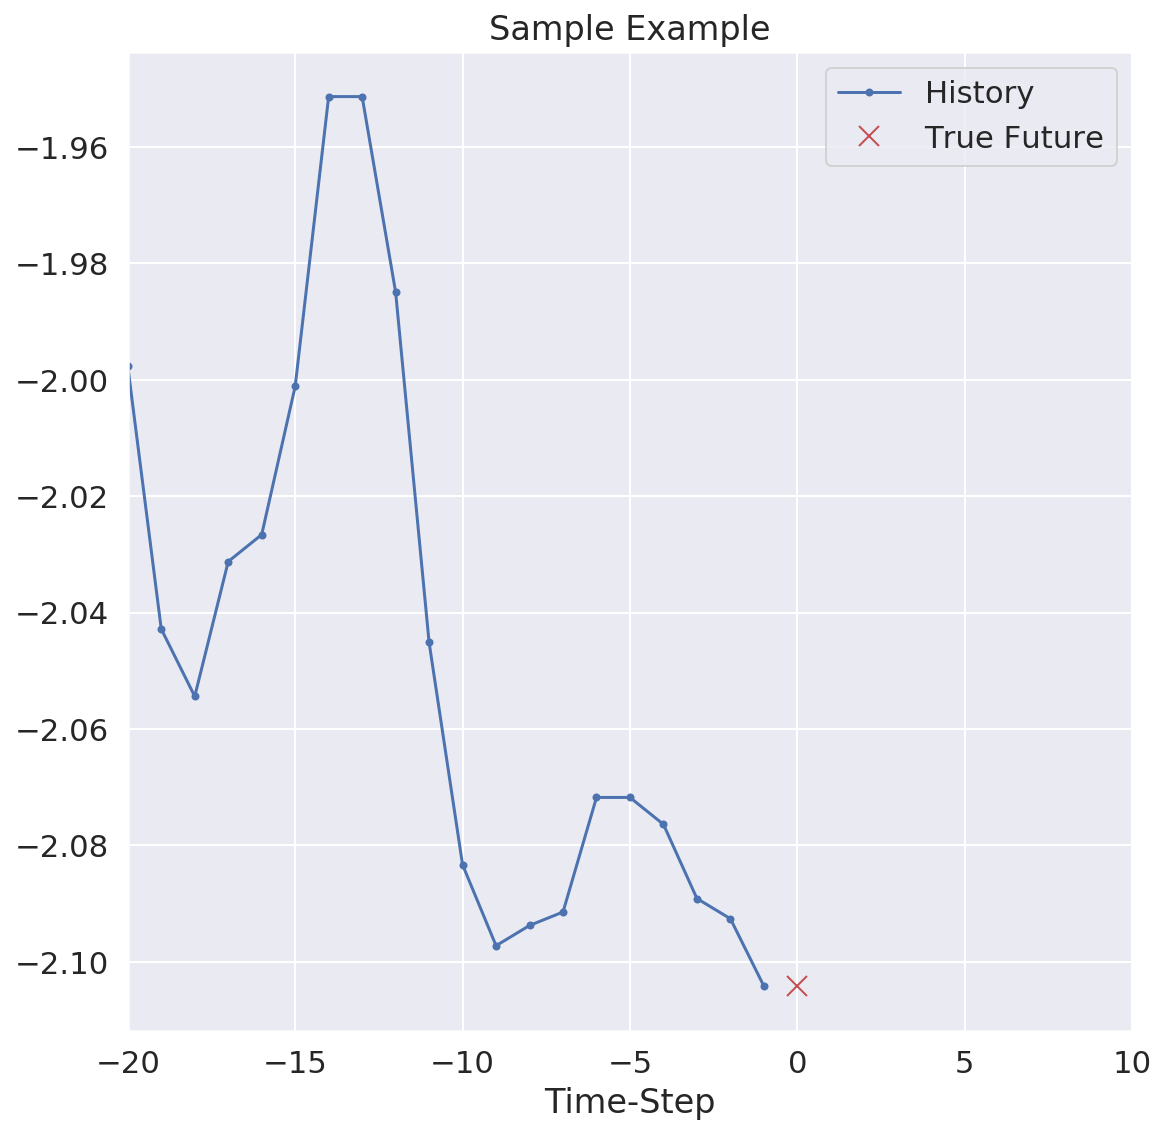

In [39]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(
            ), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

It is best practice to establish a baseline for the model, before training. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 samples.

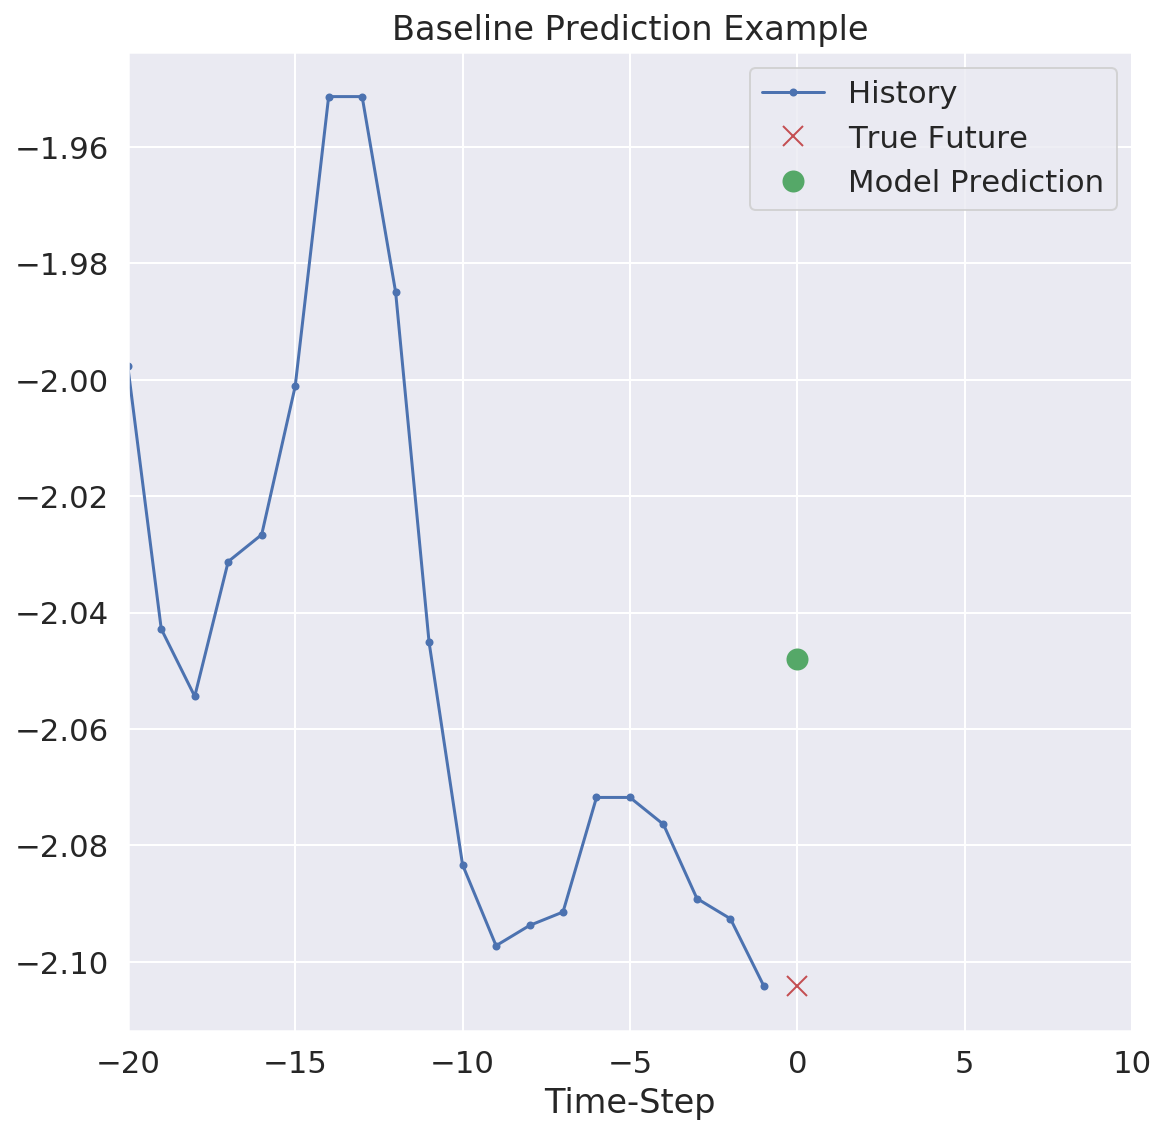

In [40]:
def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
          'Baseline Prediction Example')

Let's see if we can beat this baseline using a recurrent neural network, here using a LSTM.

### RNN Model

Here Recurrent Neural Network (RNN) is well-suited to time series data, as we've seen it is designed to model sequences of data. Here the RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [82]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

We can see the LSTM requires the input shape of the data it is being given.

In [208]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [209]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


Lets test our model by making a un-trained sample prediction, to check the output of the model

In [84]:
for x, y in val_univariate.take(1):
    print(model.predict(x).shape)

(256, 1)


Let's train the model now. However we can still use early stopping.

In [85]:
EPOCHS = 200

early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history = model.fit(train_univariate, epochs=EPOCHS,
                    validation_data=val_univariate,
                    callbacks=[early])

Epoch 1/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0630 - val_loss: 0.0234
Epoch 2/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0222 - val_loss: 0.0189
Epoch 3/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0182 - val_loss: 0.0176
Epoch 4/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 5/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 7/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 8/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0150 - val_loss: 0.0149


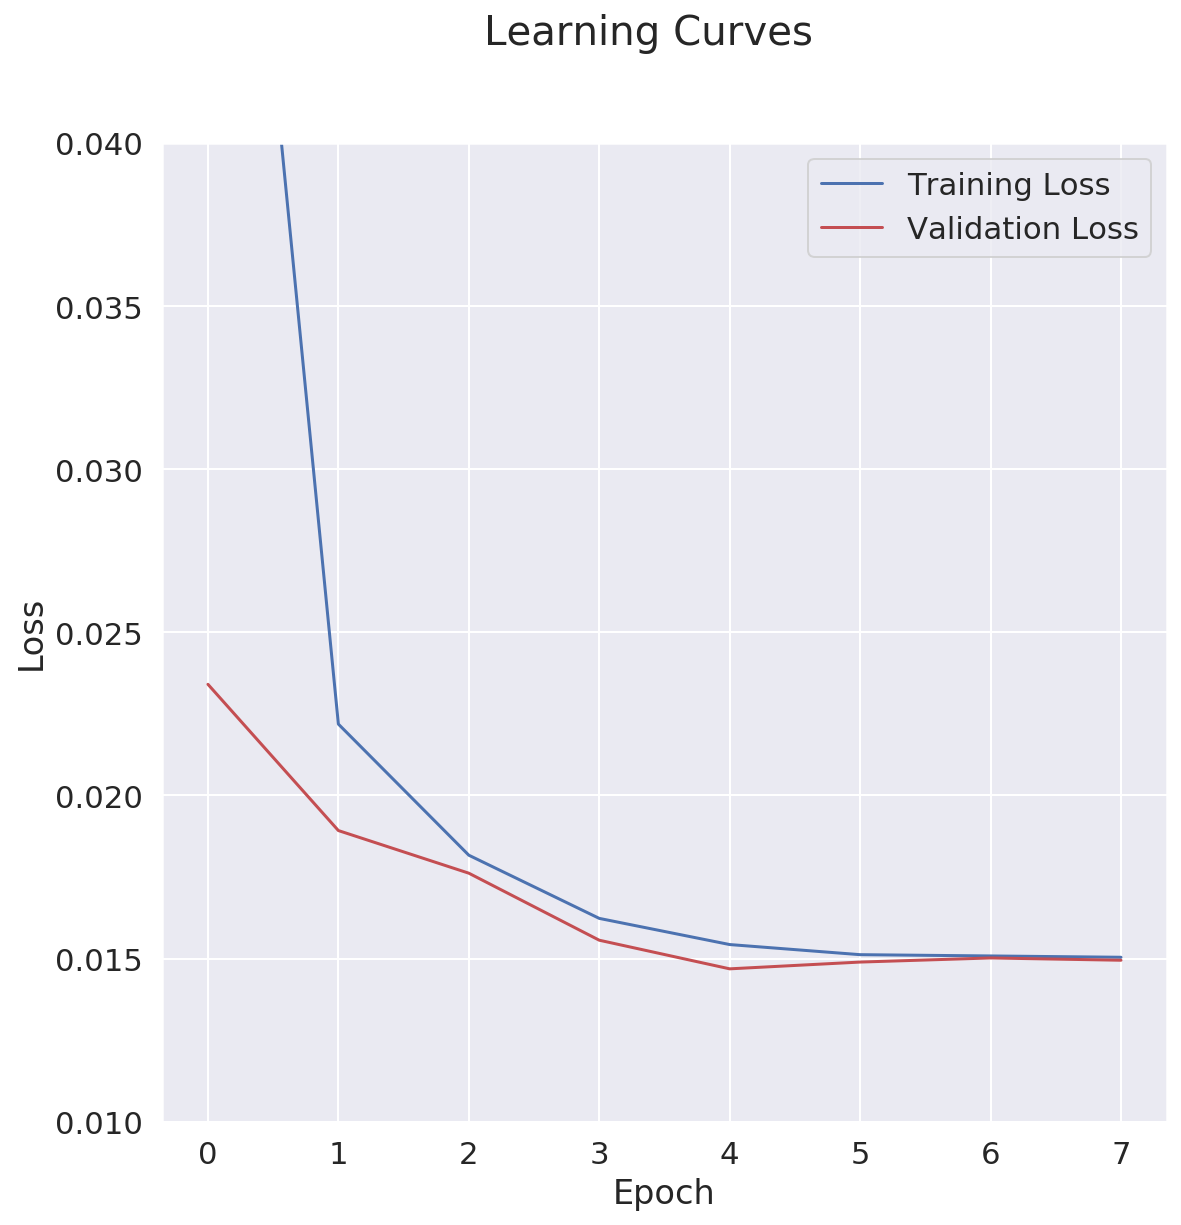

In [88]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylim(0.01, 0.04)
plt.ylabel("Loss")
plt.show()

#### Testing our predictions with the model
Now that we have trained our simple LSTM model we can try to make a few predictions

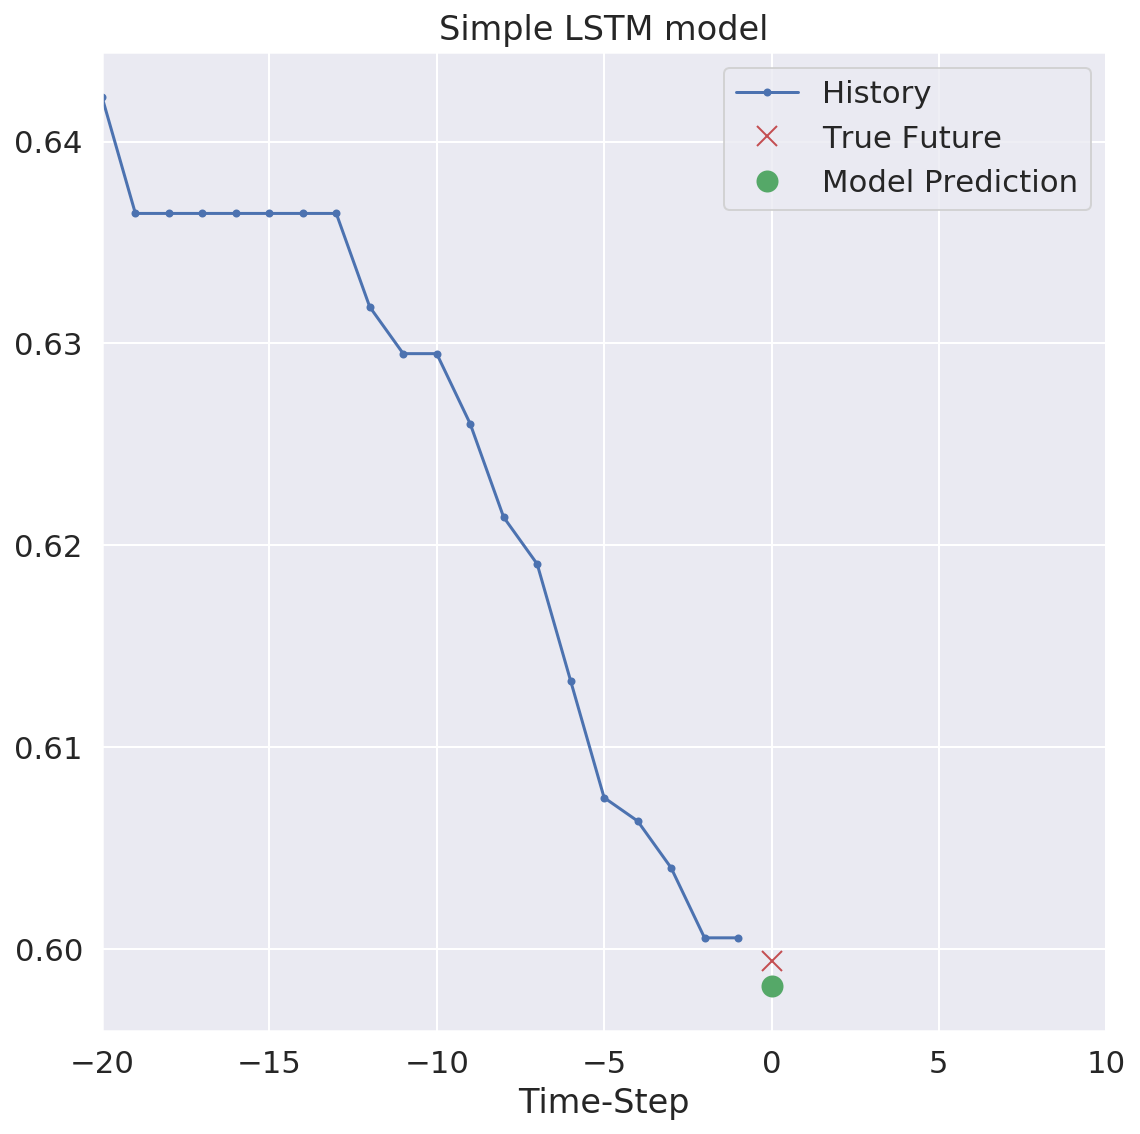

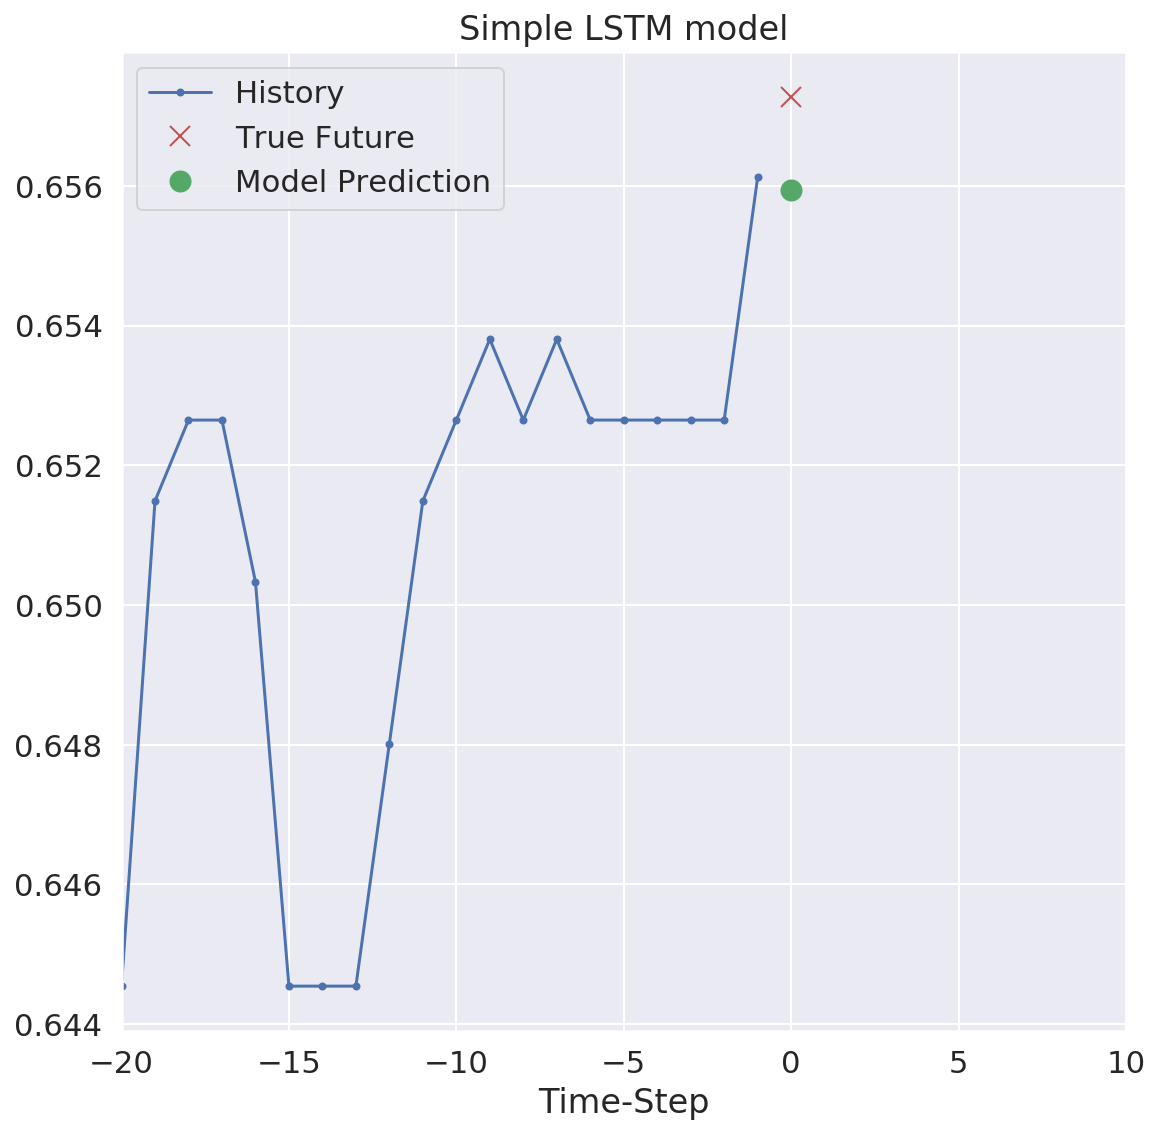

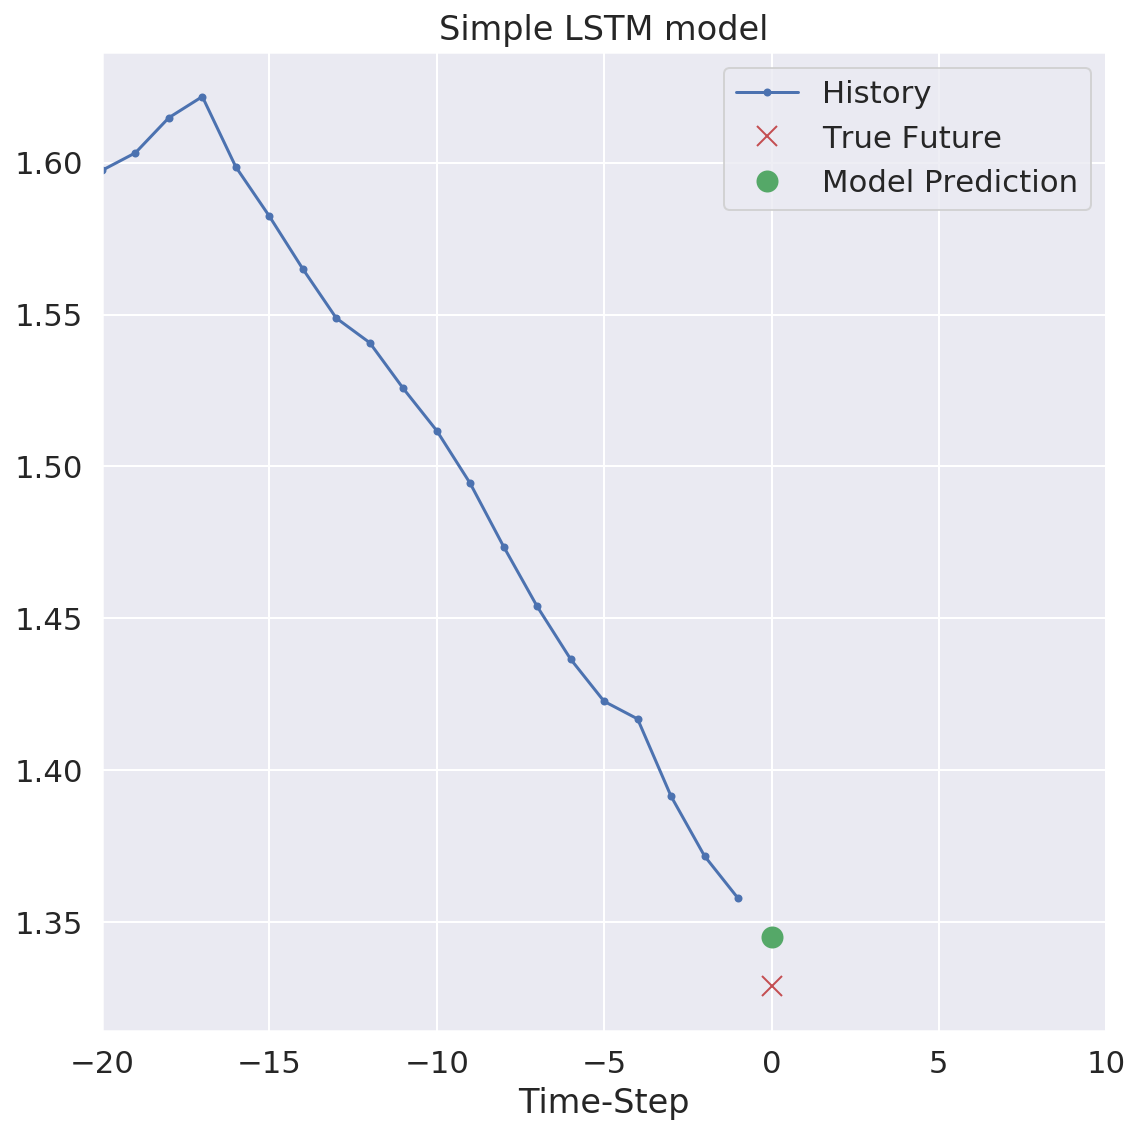

In [89]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')

This looks better than the baseline.

## Forecasting a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

In [92]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [93]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

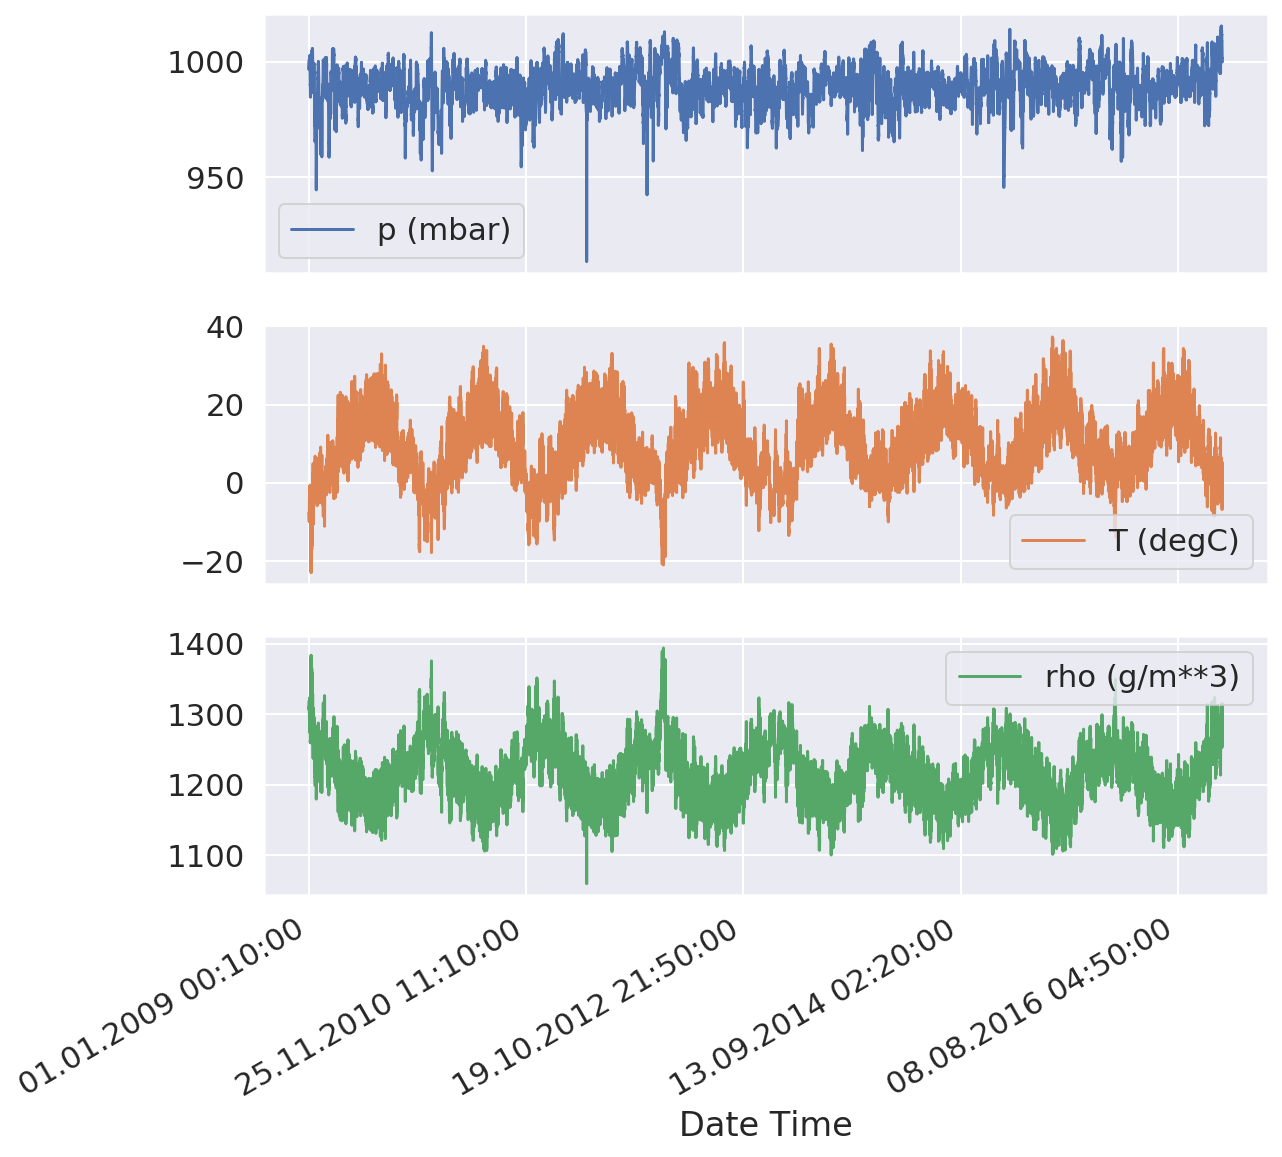

In [95]:
features.plot(subplots=True)
plt.show()

As mentioned, the first step will be to standardize the dataset to have zero mean and unit variance, by using the training data.

In [97]:
dataset = features.values
scaler = StandardScaler().fit(dataset[:TRAIN_SPLIT])
dataset = scaler.transform(dataset)

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task, as we saw above, however, here it samples the past observation based on the step size given.

In [113]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Here the network is shown data from the last five 5 days, i.e. 720 samples that are sampled every hour. The sampling is done every hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 12*6 = 72 samples is used.

In [114]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [115]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [116]:
train_data_single = tf.data.Dataset.from_tensor_slices(
    (x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices(
    (x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [157]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse')

Let's check out a sample prediction.

In [158]:
for x, y in val_data_single.take(1):
    print(model.predict(x).shape)

(256, 1)


In [159]:
early = tf.keras.callbacks.EarlyStopping('val_loss', patience=1)

history = model.fit(train_data_single, epochs=EPOCHS,
                    validation_data=val_data_single,
                    callbacks=[early])

Epoch 1/200
1170/1170 [==============================] - 11s 10ms/step - loss: 0.1337 - val_loss: 0.1164
Epoch 2/200
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0976 - val_loss: 0.1125
Epoch 3/200
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0938 - val_loss: 0.1086
Epoch 4/200
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0901 - val_loss: 0.1046
Epoch 5/200
1170/1170 [==============================] - 11s 10ms/step - loss: 0.0869 - val_loss: 0.1050


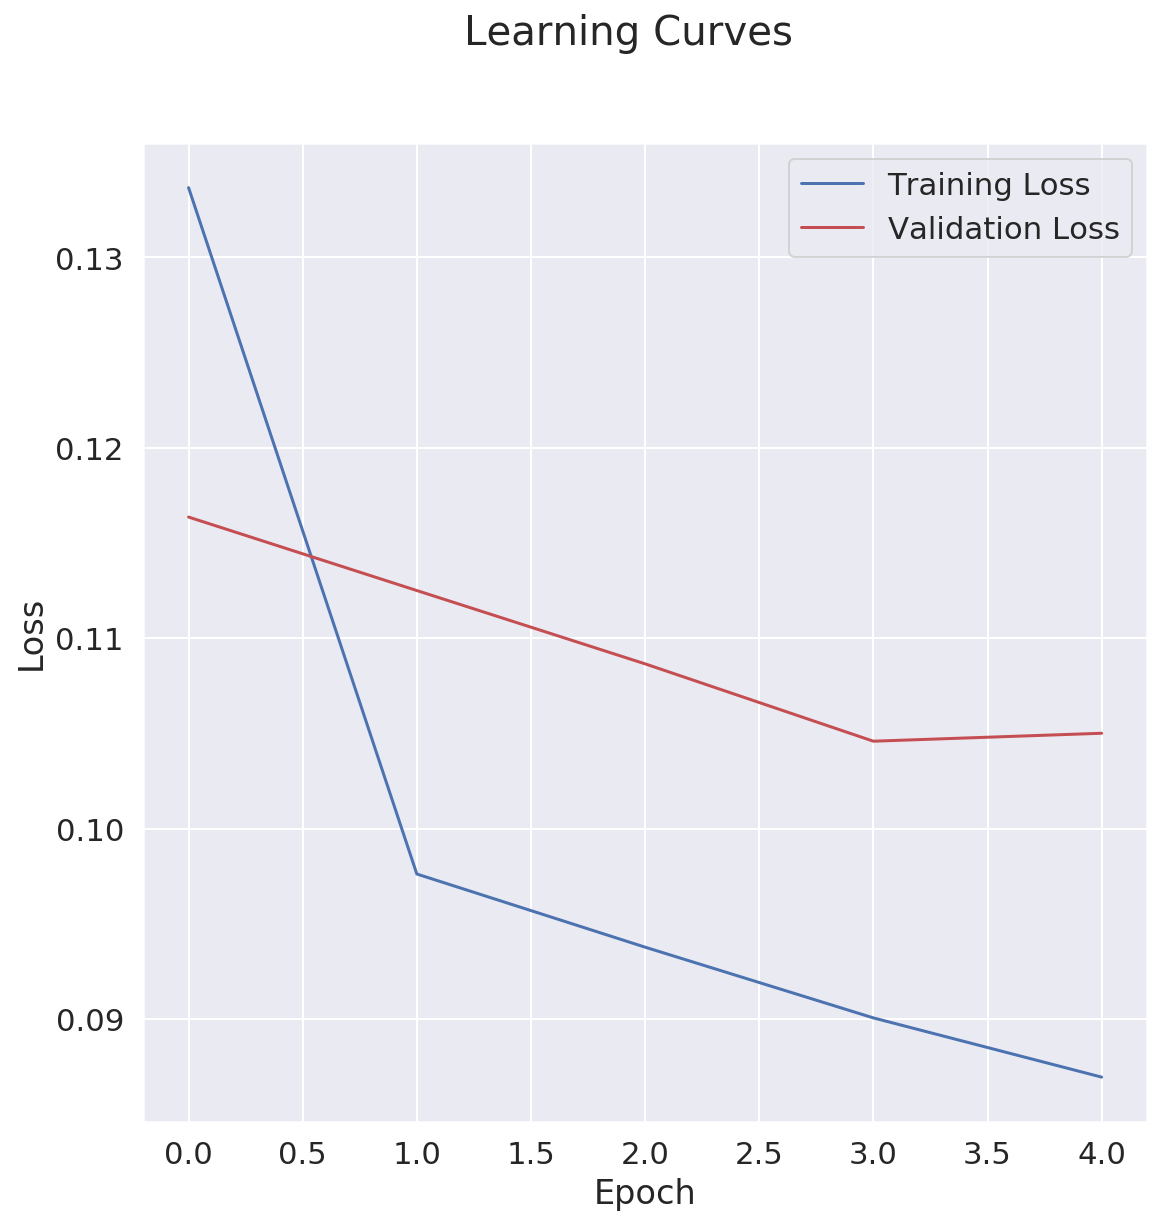

In [160]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

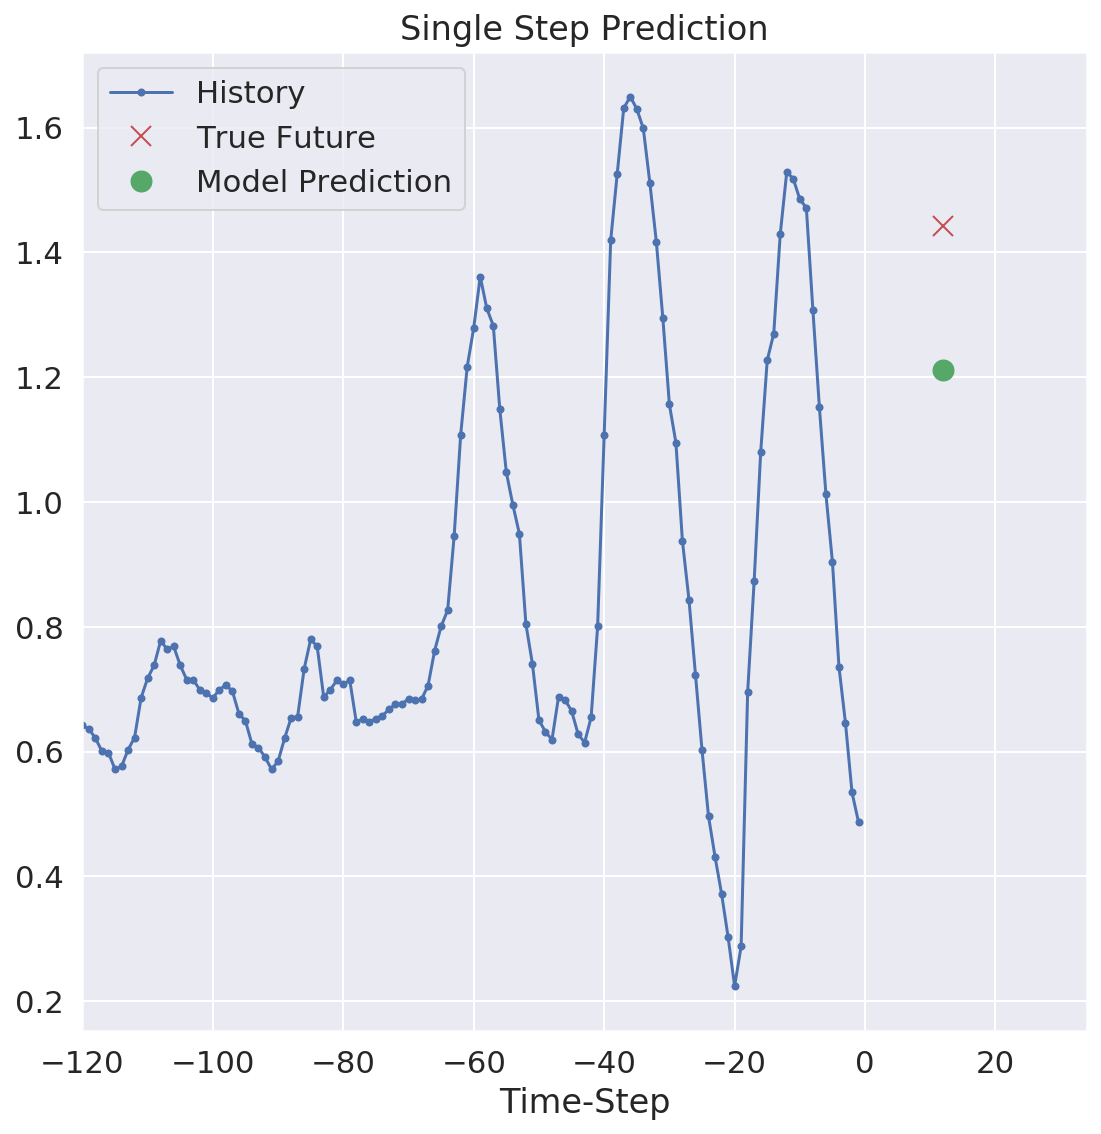

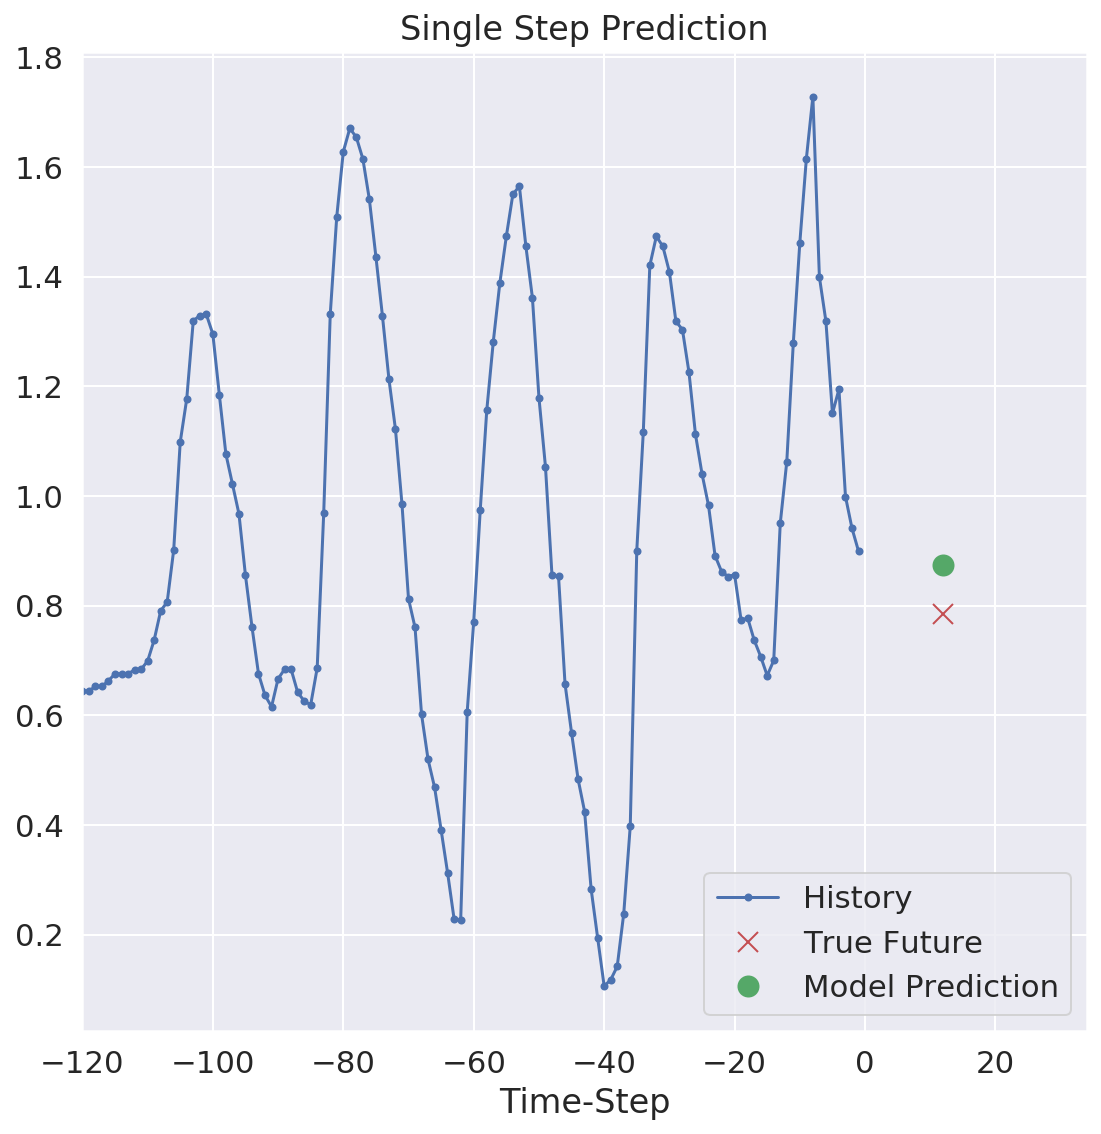

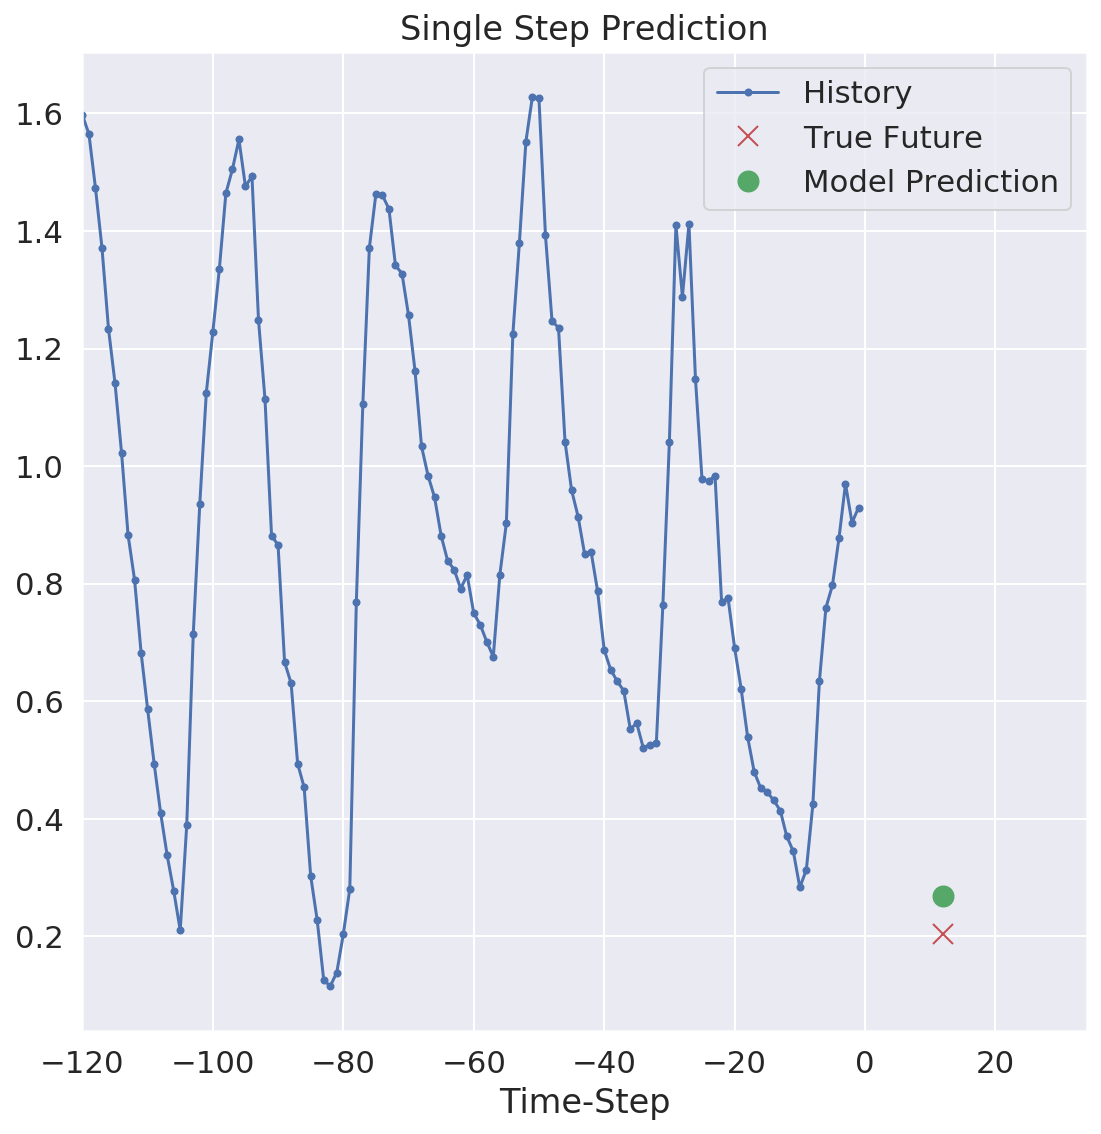

In [161]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      model.predict(x)[0]], 12,
                     'Single Step Prediction')

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an sample is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [162]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [163]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [164]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

Plotting a sample data-point.

In [165]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

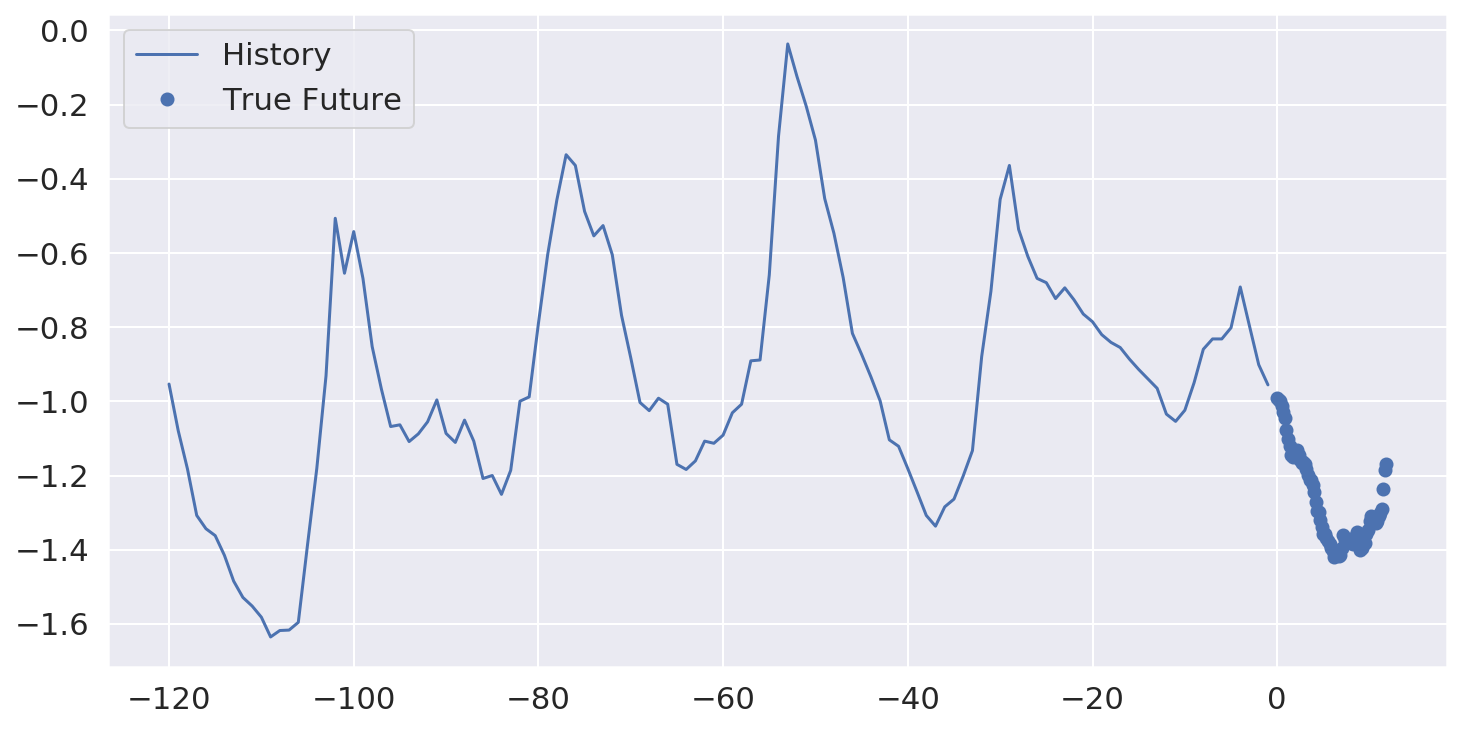

In [166]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [197]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True,
                         input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, dropout=0.2),
    tf.keras.layers.Dense(72),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss='mae')

Let's see how the model predicts before it trains.

In [198]:
for x, y in val_data_multi.take(1):
    print(model.predict(x).shape)

(256, 72)


In [199]:
early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history = model.fit(train_data_multi, epochs=EPOCHS,
                    validation_data=val_data_multi,
                    callbacks=[early])

Epoch 1/200
1170/1170 [==============================] - 19s 16ms/step - loss: 0.2862 - val_loss: 0.2168
Epoch 2/200
1170/1170 [==============================] - 18s 15ms/step - loss: 0.1963 - val_loss: 0.2057
Epoch 3/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1846 - val_loss: 0.1930
Epoch 4/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1786 - val_loss: 0.1890
Epoch 5/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1752 - val_loss: 0.1903
Epoch 6/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1727 - val_loss: 0.1893
Epoch 7/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1710 - val_loss: 0.1862
Epoch 8/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1688 - val_loss: 0.1881
Epoch 9/200
1170/1170 [==============================] - 18s 16ms/step - loss: 0.1677 - val_loss: 0.1868
Epoch 10/200
1170/1170 [==============================]

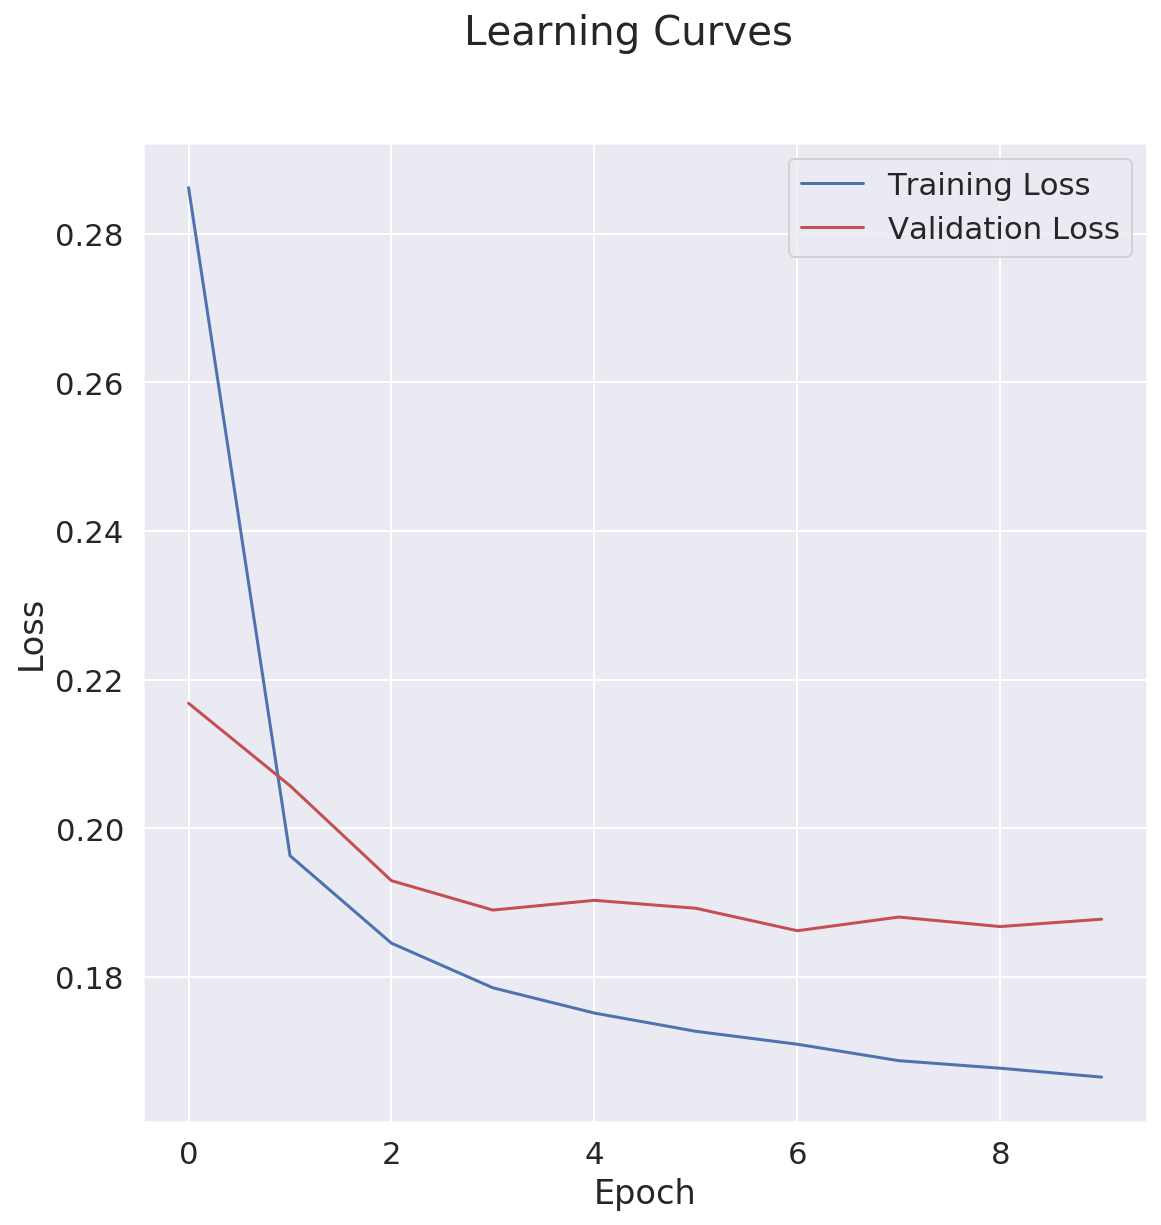

In [200]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Predict a multi-step future
Let's now have a look at how well our network has learnt to predict the future.

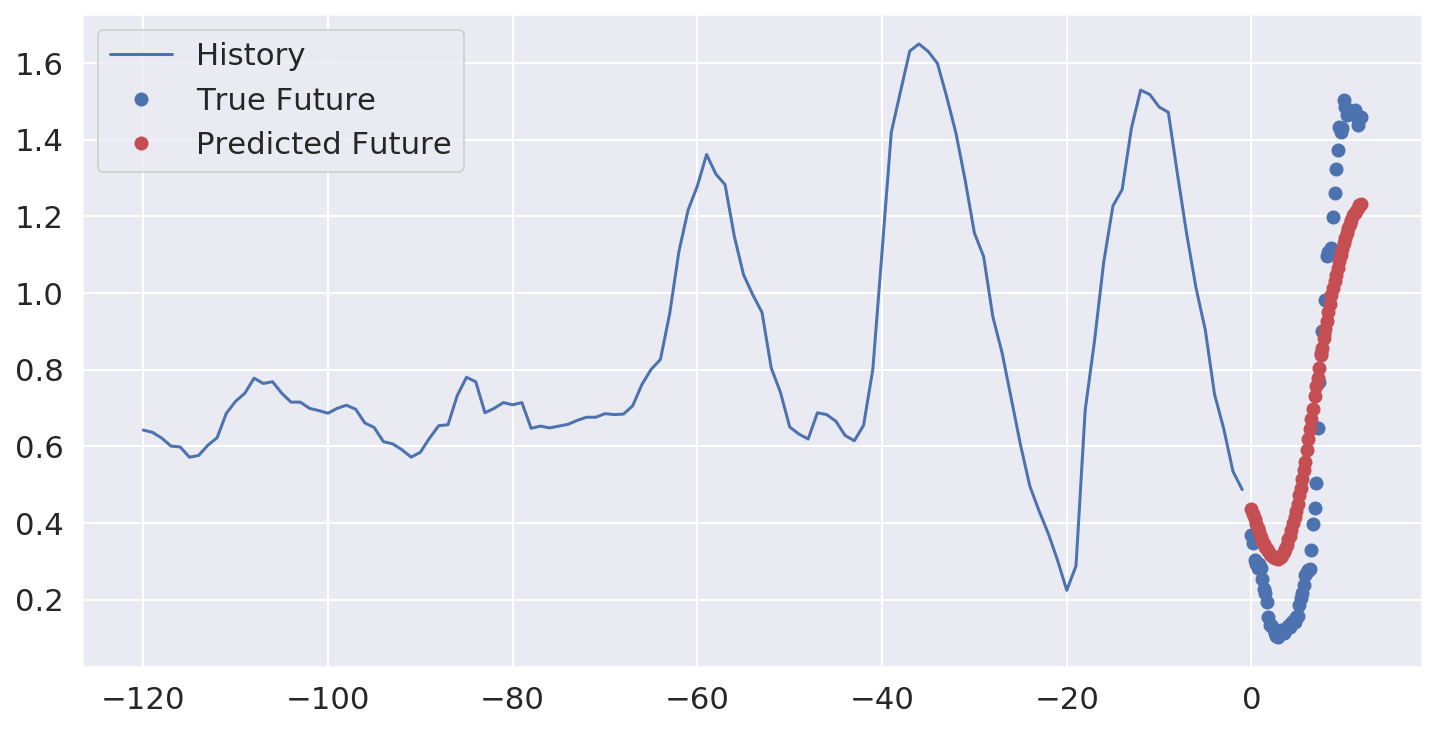

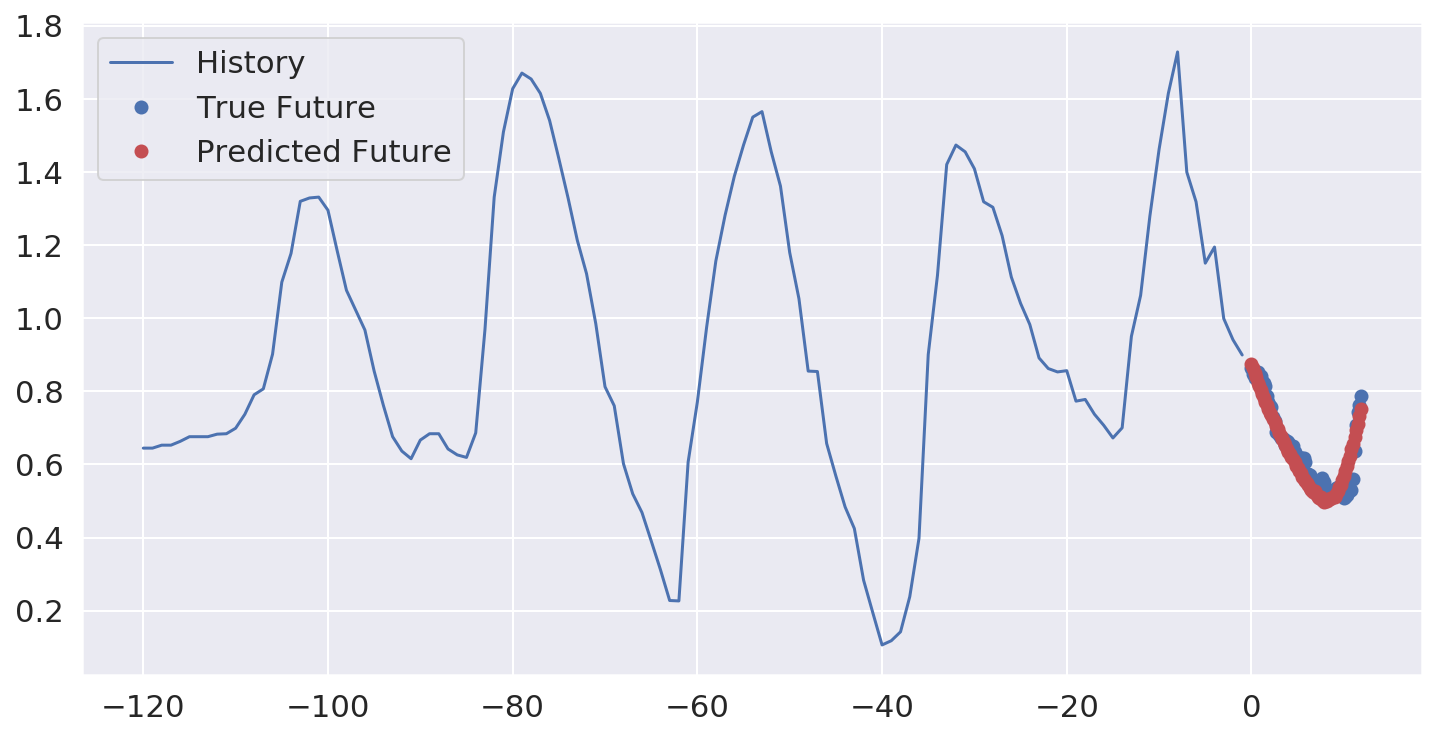

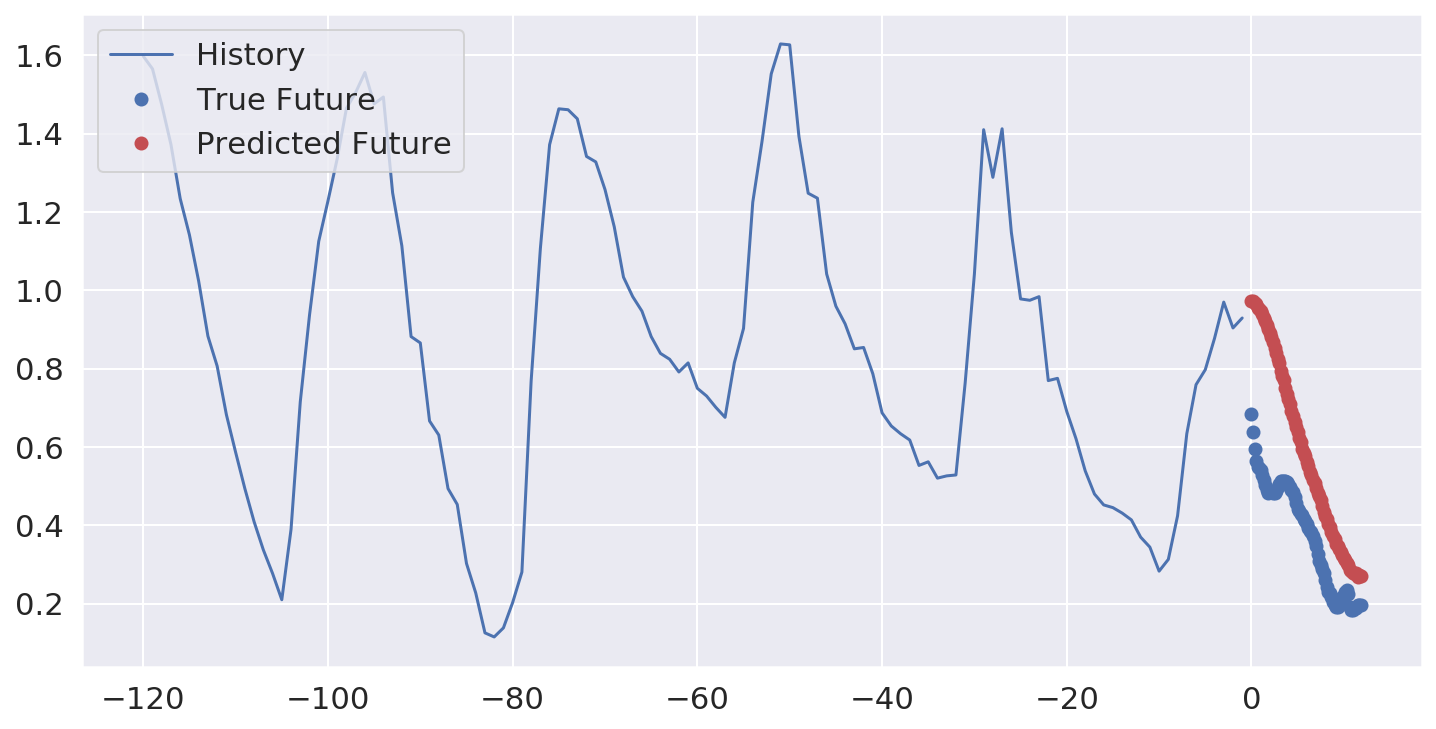

In [201]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], model.predict(x)[0])

## Processing sequences with ConvNets

Another variation for processing sequences is to use $1D$ ConvNets, where time is the spatial dimension for the ConvNet. $1D$ ConvNets have a lower computational cost, however may provide similar model capacity and performance as RNNs in specific tasks. They have shown great promise with dilated kernels for machine translation and audio generation. These $1D$ ConvNets can recognise local patterns in sequences which are translation invariant in time. Here pooling is analagous to processing a sequence into a smaller subsequence.

We can use the `tf.keras.layers.Conv1D` layer. This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. 

When we use this layer as the first layer in a model, we have to provide an input_shape argument (tuple of integers or None, e.g. `(10, 128)` for sequences of 10 vectors of 128-dimensional vectors, or `(None, 128)` for variable-length sequences of 128-dimensional vectors. We have to specify the `filters`, and `kernel_size`. It's full parameters are:
* `filters` : Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* `kernel_size` : An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
* `strides` : An integer or tuple/list of a single integer, specifying the stride length of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
* `padding` : One of "valid", "causal" or "same" (case-insensitive). "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio.
* `data_format` : A string, one of channels_last (default) or channels_first.
* `dilation_rate` : an integer or tuple/list of a single integer, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1  is incompatible with specifying any strides value != 1.
* `activation` : Activation function to use. If you don't specify anything, no activation is applied ( see keras.activations).
* `use_bias` : Boolean, whether the layer uses a bias vector.
* `kernel_initializer` : Initializer for the kernel weights matrix ( see keras.initializers).
* `bias_initializer` : Initializer for the bias vector ( see keras.initializers).
* `kernel_regularizer` : Regularizer function applied to the kernel weights matrix (see keras.regularizers).
* `bias_regularizer` : Regularizer function applied to the bias vector ( see keras.regularizers).
* `activity_regularizer` : Regularizer function applied to the output of the layer (its "activation") ( see keras.regularizers).
* `kernel_constraint` : Constraint function applied to the kernel matrix ( see keras.constraints).
* `bias_constraint` : Constraint function applied to the bias vector ( see keras.constraints).

It takes as input a $3D$ tensor with shape: `(batch_size, steps, input_dim)` and has an output $3D$ tensor with shape: `(batch_size, new_steps, filters)`, the steps value might have changed due to padding or strides.

### Combining CNNs and RNNs for long sequence processing

$1D$ ConvNets are translation invariant in time, making them not sensitive to the order of timesteps beyond the local convolution window size, unlike RNNs. If the problem requires long orders for good prediction (such as our temperature dataset), simple $1D$ Convolutional layers would perform badly, with a small window size. Instead it is known to combine a $1D$ ConvNet to process a large sequence into a smaller sub-sequence which can be fed into a RNN. One way to increase the sequence length is to look at larger time windows, or to increase the time resolution to provide more samples within a given time window.

In [218]:
x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_scaled, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [226]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu', input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16, 32)            192       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1, 32)             5152      
_________________________________________________________________
lstm_48 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.compile(optimizer='adam', loss='mae')
early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history = model.fit(train_univariate, epochs=EPOCHS,
                    validation_data=val_univariate,
                    callbacks=[early])

Epoch 1/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0736 - val_loss: 0.0375
Epoch 2/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0382 - val_loss: 0.0355
Epoch 3/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0366 - val_loss: 0.0342
Epoch 4/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0357 - val_loss: 0.0329
Epoch 5/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0345 - val_loss: 0.0322
Epoch 6/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0336 - val_loss: 0.0324
Epoch 7/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0330 - val_loss: 0.0306
Epoch 8/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0323 - val_loss: 0.0298
Epoch 9/200
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0317 - val_loss: 0.0297
Epoch 10/200
1172/1172 [==============================] - 6s 5ms/step - l

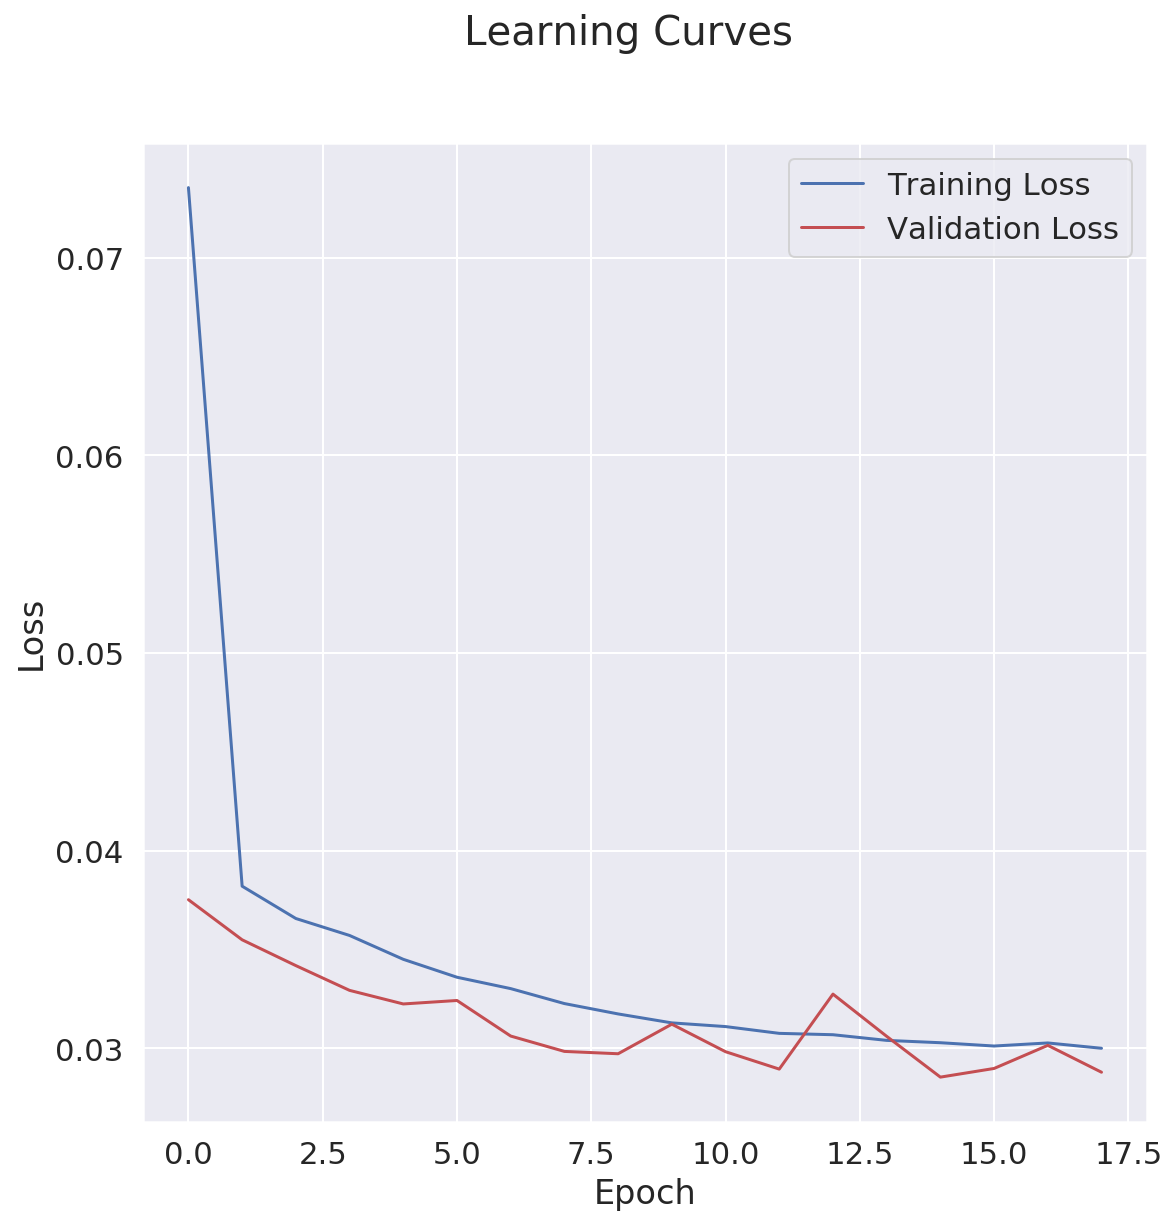

In [230]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

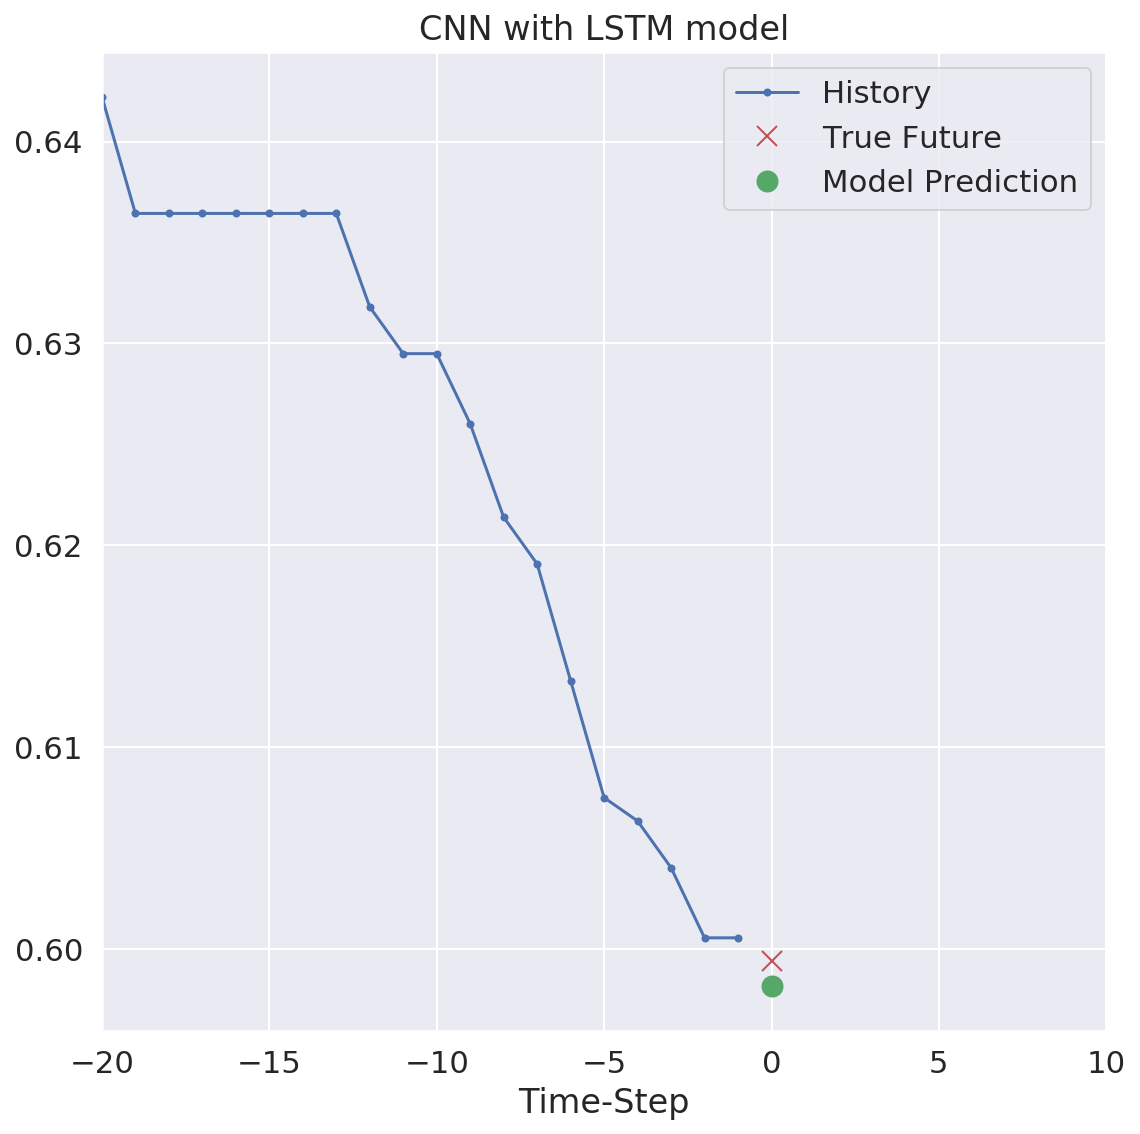

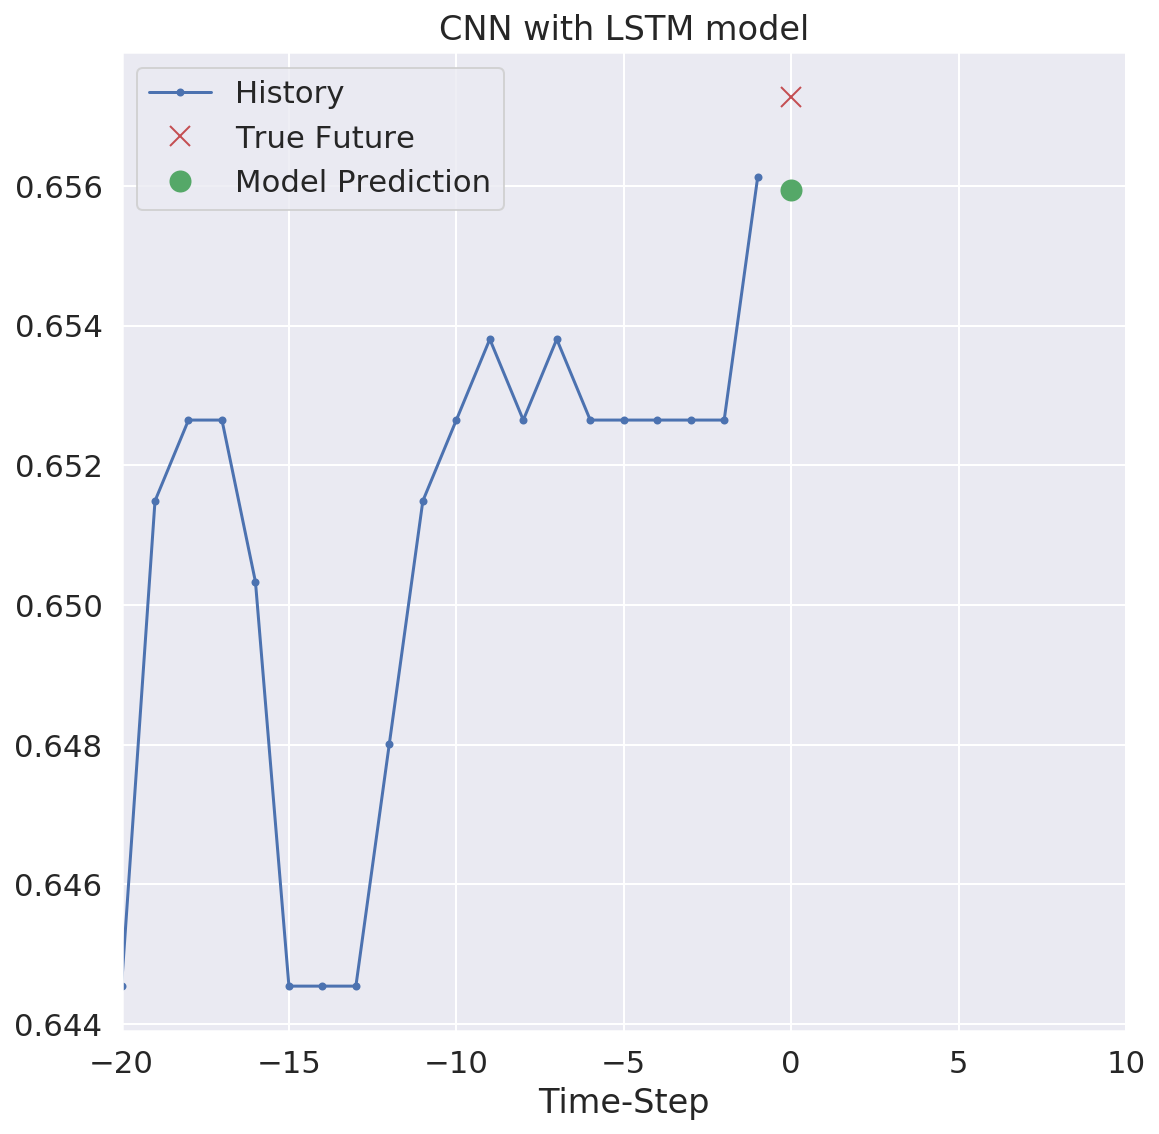

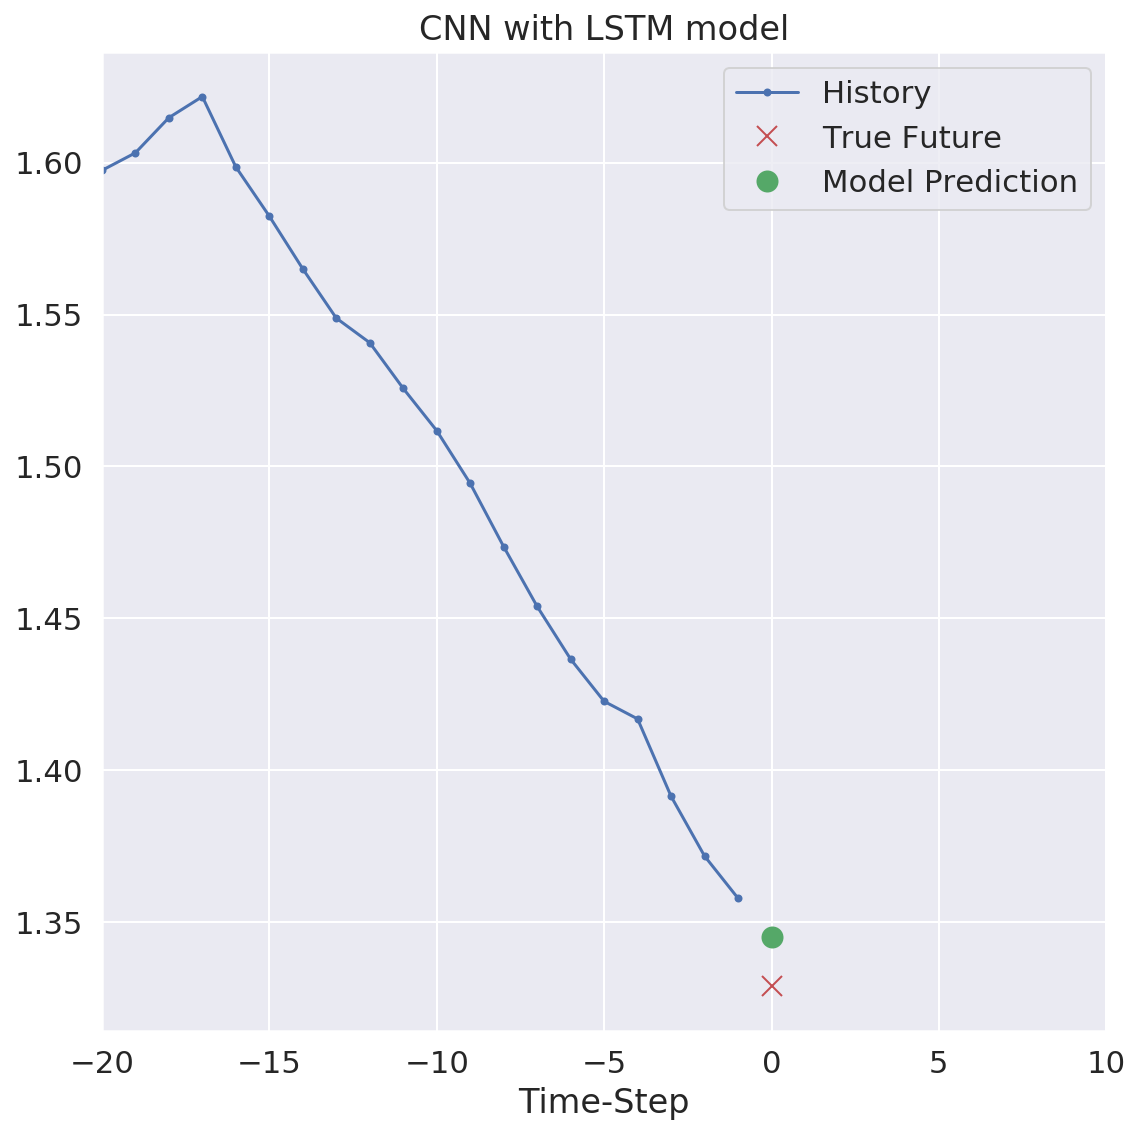

In [231]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'CNN with LSTM model')

## Mulitple CNNs - WaveNet with LSTM

Stacking muliple CNNs, as seen in *Wavenet* in [2016](https://arxiv.org/abs/1609.03499). We can stack $1D$ convolutional layers, doubling the dilation rate at each layer. This allows the lower layers to learn short term patterns and the higher layers to learn long term patterns. 

I have added an LSTM layer on the output here (As an experimentation), however we could also replace this with a dense layer output.

In [239]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
dilation_rates = (1, 2, 4, 8) * 2
for rate in dilation_rates:
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_50 (Conv1D)           (None, None, 32)        

In [240]:
model.compile(optimizer='adam', loss='mae')
early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history = model.fit(train_univariate, epochs=EPOCHS,
                    validation_data=val_univariate,
                    callbacks=[early])

Epoch 1/200
1172/1172 [==============================] - 11s 9ms/step - loss: 0.0805 - val_loss: 0.0215
Epoch 2/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0257 - val_loss: 0.0202
Epoch 3/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0231 - val_loss: 0.0170
Epoch 4/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0216 - val_loss: 0.0175
Epoch 5/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0207 - val_loss: 0.0155
Epoch 6/200
1172/1172 [==============================] - 10s 8ms/step - loss: 0.0215 - val_loss: 0.0169
Epoch 7/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0202 - val_loss: 0.0152
Epoch 8/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0185 - val_loss: 0.0155
Epoch 9/200
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0197 - val_loss: 0.0154
Epoch 10/200
1172/1172 [==============================] - 10s 8m

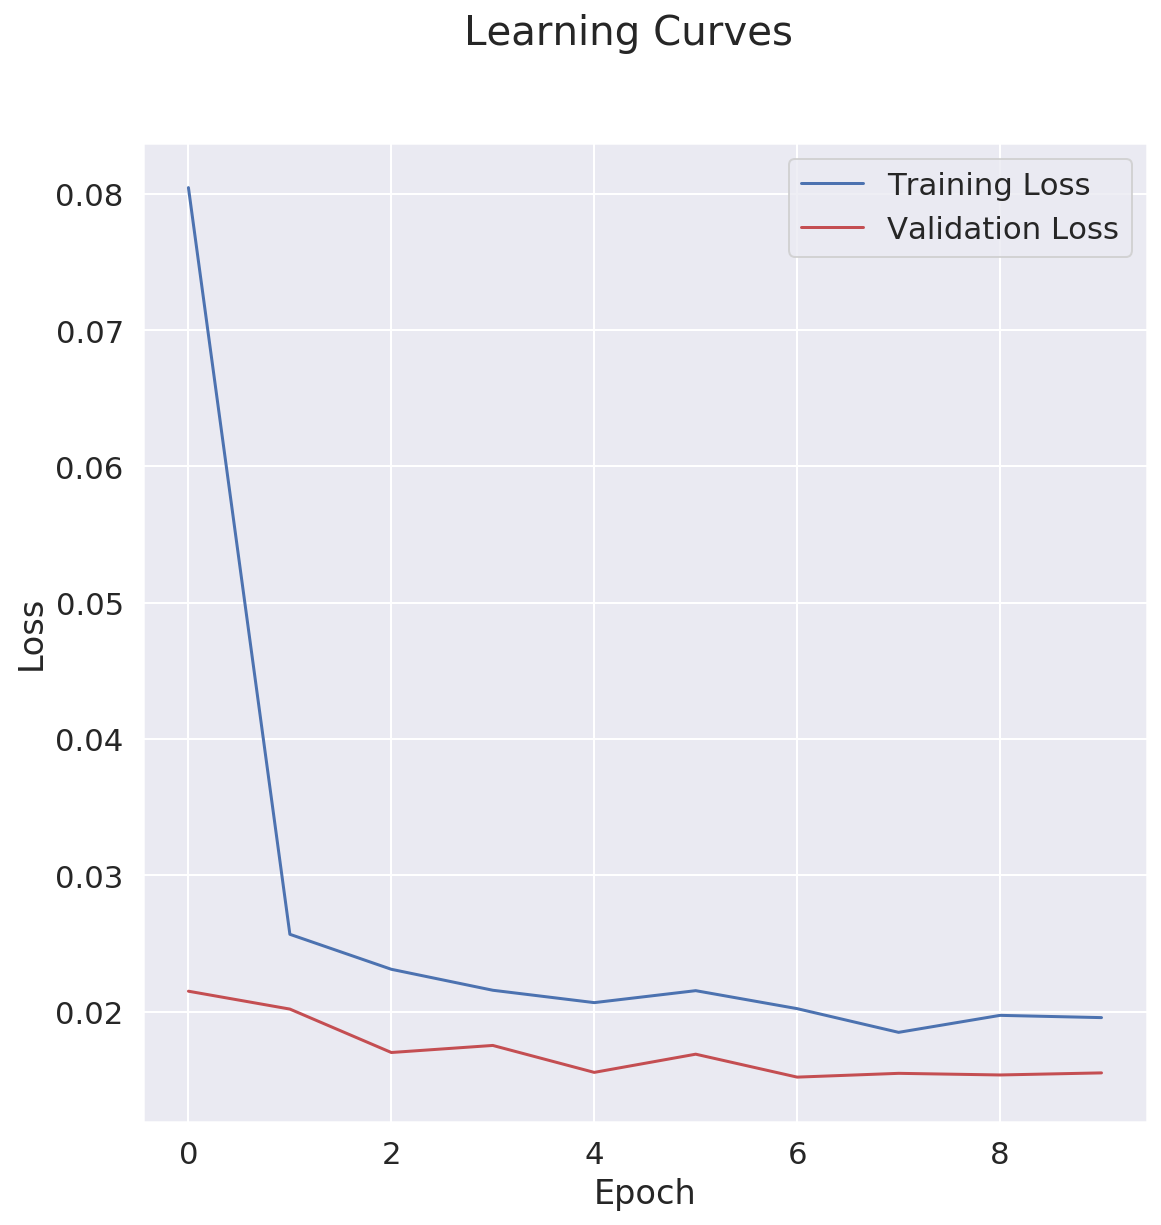

In [242]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

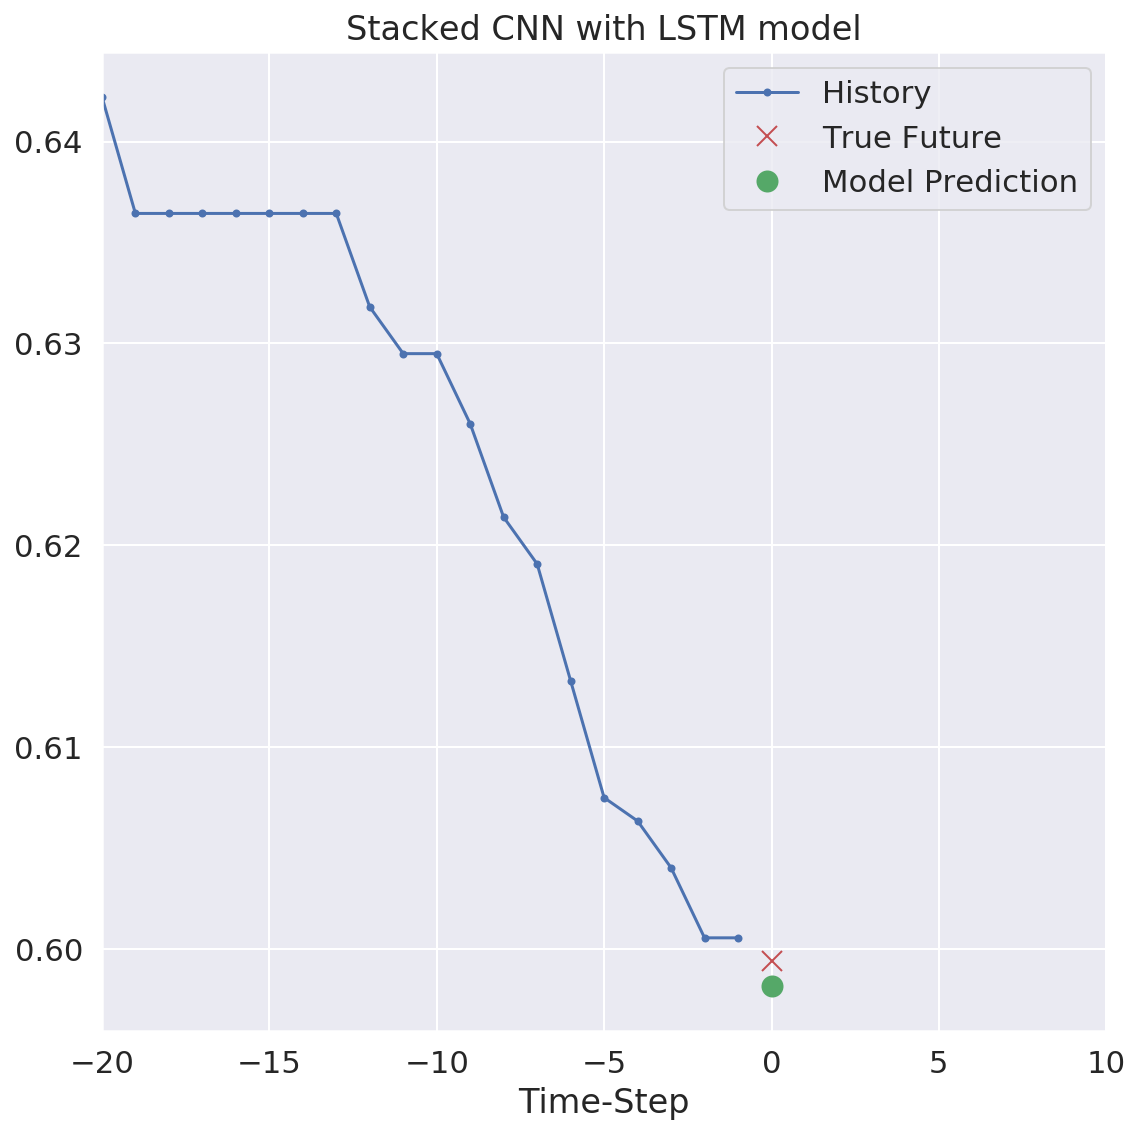

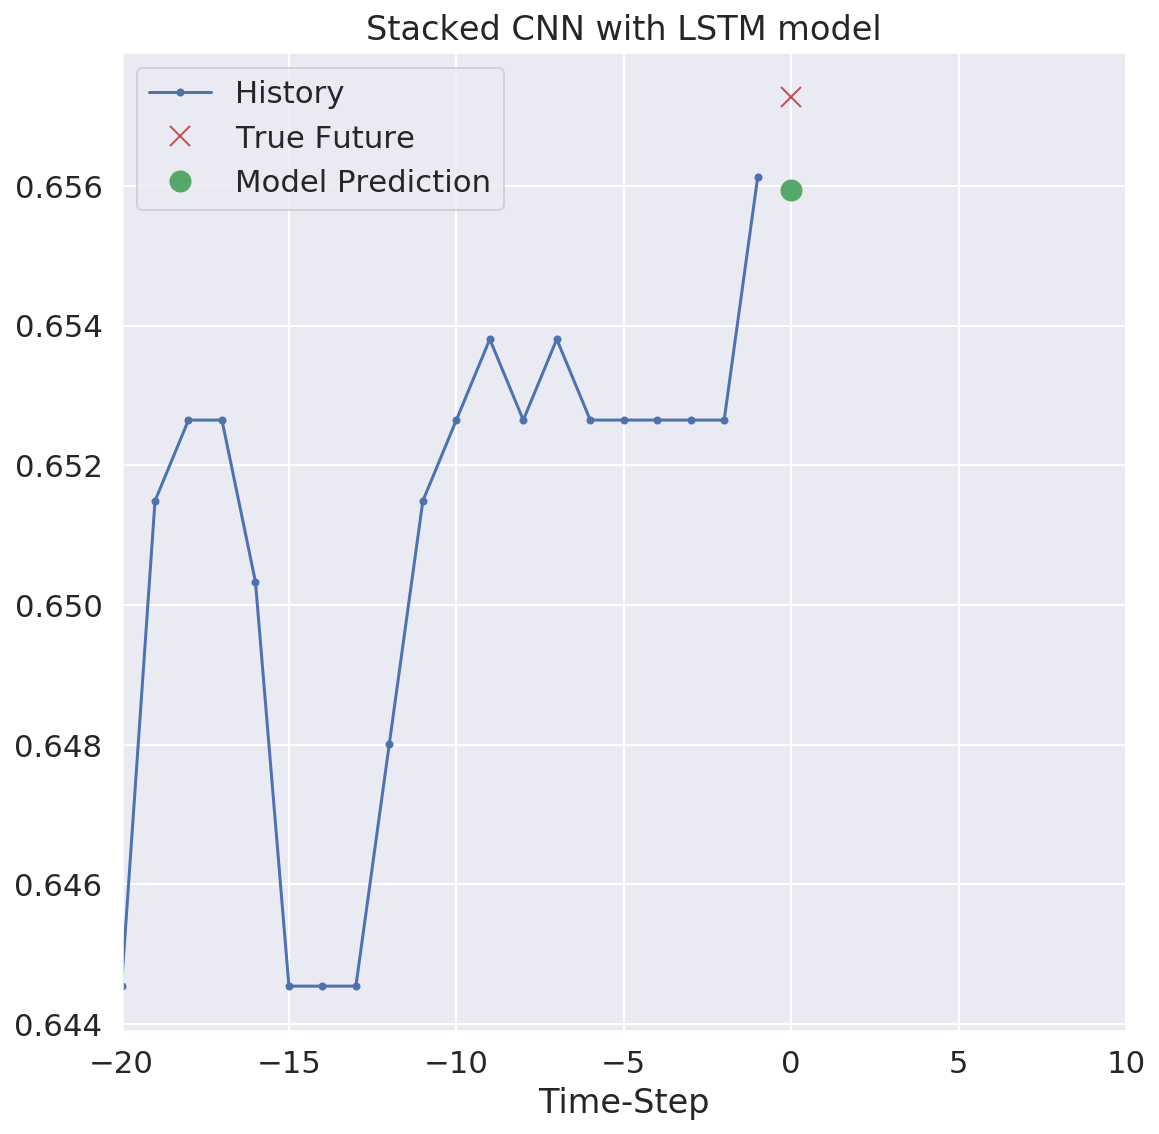

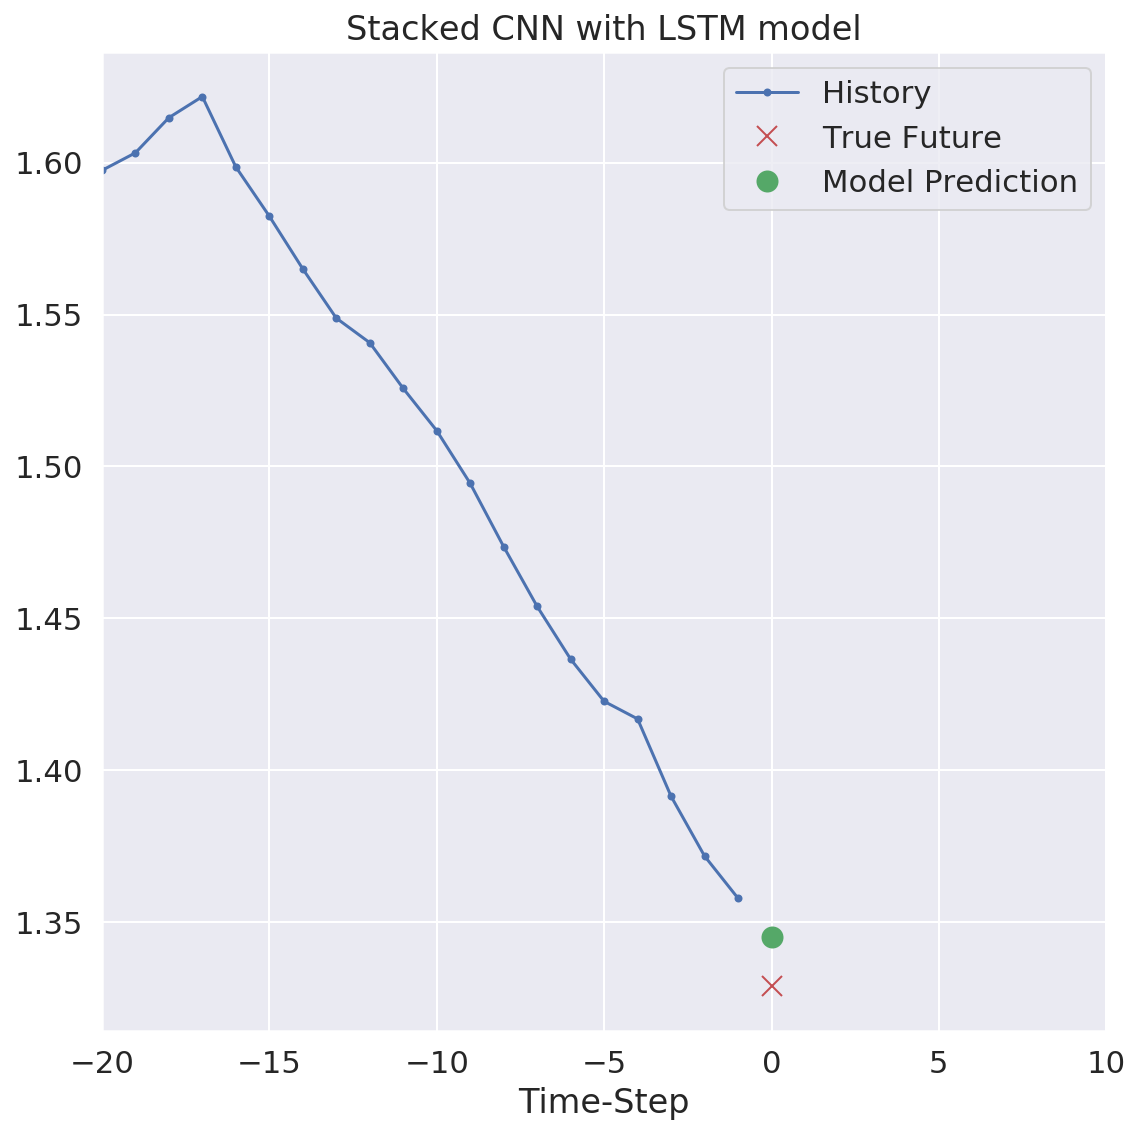

In [243]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Stacked CNN with LSTM model')